In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 0. Task

Needs predict total sales for every product and store in the next month.

import libraries

In [49]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

import matplotlib.pyplot as plt
import seaborn as sns

import sweetviz as sv

import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif # anova
from sklearn.feature_selection import chi2 # хи-квадрат

plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)

LigthAutoML config

In [50]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 10
TEST_SIZE = 0.2
TIMEOUT = 30 * 60 # equal to 15 minutes
TARGET_NAME = 'item_cnt_month'

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

Import data

In [51]:
INPUT_DIR = 'data/'

In [52]:
items = pd.read_csv(INPUT_DIR + 'items.csv')
categories = pd.read_csv(INPUT_DIR + 'item_categories.csv')
shops = pd.read_csv(INPUT_DIR + 'shops.csv')

display(items.head(3))
display(categories.head(3))
display(shops.head(3))

train_data = pd.read_csv(INPUT_DIR + 'sales_train.csv')
train_data = train_data.merge(items, how='left', on='item_id')

display(train_data.head(3))
print(train_data.shape)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,02.01.2013,0,59,22154,999.00,1.00,ЯВЛЕНИЕ 2012 (BD),37
1,03.01.2013,0,25,2552,899.00,1.00,DEEP PURPLE The House Of Blue Light LP,58
2,05.01.2013,0,25,2552,899.00,-1.00,DEEP PURPLE The House Of Blue Light LP,58


(2935849, 8)


In [53]:
train_data = train_data.merge(shops, how='left', on='shop_id')
train_data = train_data.merge(categories, how='left', on='item_category_id')

train_data.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,02.01.2013,0,59,22154,999.00,1.00,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.00,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил


In [54]:
test_data = pd.read_csv(INPUT_DIR + 'test.csv')
test_data = test_data.join(items, how='left', on='item_id', rsuffix='_r')

display(test_data.head(3))
print(test_data.shape)

,ID,shop_id,item_id,item_name,item_id_r,item_category_id
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",5037,19
1,1,5,5320,ONE DIRECTION Made In The A.M.,5320,55
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",5233,19


(214200, 6)


Make test data like train data. We should add in test data next columns: item_cnt_month, month (next month) and item_price

In [55]:
train_data['date'] = pd.to_datetime(train_data['date'], format='%d.%m.%Y')
train_data['month'] = train_data['date'].dt.month
train_data['year'] = train_data['date'].dt.year

In [56]:
item_prices = train_data[['item_id', 'item_price']]

test_data = test_data.join(item_prices, how='left', on='item_id', rsuffix='_r')

# next month
# date_block_num - January 2013 is 0, February 2013 is 1,..., October 2015 is 33
test_data['date_block_num'] = train_data['date_block_num'].max() + 1
test_data['month'] = test_data['date_block_num'] % 12
test_data['year'] = train_data['year'].max()

In [57]:
test_data = test_data.merge(shops, how='left', on='shop_id')
test_data = test_data.merge(categories, how='left', on='item_category_id')

test_data.set_index(test_data['ID'])

test_data.drop(['item_id_r', 'ID'], axis = 1, inplace=True)
test_data.head(2)

,shop_id,item_id,item_name,item_category_id,item_price,date_block_num,month,year,shop_name,item_category_name
0,5,5037,"NHL 15 [PS3, русские субтитры]",19,399.00,34,10,2015,"Вологда ТРЦ ""Мармелад""",Игры - PS3
1,5,5320,ONE DIRECTION Made In The A.M.,55,599.00,34,10,2015,"Вологда ТРЦ ""Мармелад""",Музыка - CD локального производства


# 1. Clear data

Let's look up onto our dataframe

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,month,year
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00,6.25,2013.78
std,9.42,16.23,6324.30,1729.80,2.62,17.10,3.54,0.77
min,0.00,0.00,0.00,-1.00,-22.00,0.00,1.00,2013.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00,3.00,2013.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00,6.00,2014.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00,9.00,2014.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00,12.00,2015.00


array([[<AxesSubplot:title={'center':'date'}>,
        <AxesSubplot:title={'center':'date_block_num'}>,
        <AxesSubplot:title={'center':'shop_id'}>],
       [<AxesSubplot:title={'center':'item_id'}>,
        <AxesSubplot:title={'center':'item_price'}>,
        <AxesSubplot:title={'center':'item_cnt_day'}>],
       [<AxesSubplot:title={'center':'item_category_id'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'year'}>]], dtype=object)

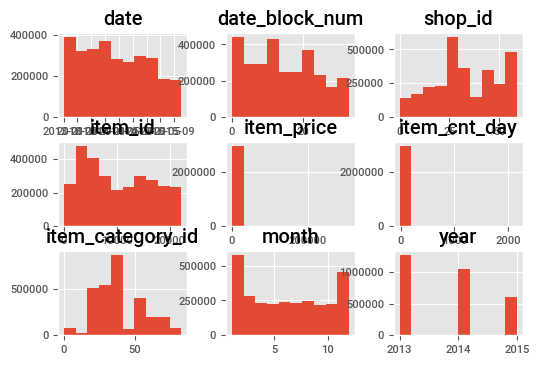

In [58]:
display(train_data.describe())

hist = train_data.hist()
hist

- As we see, we have outliers by item_price and item_cnt_day, also item_cnt_day and item_price - can not be less 0, let's remove values less 0.
- Also we can see that item_price and item_id has a very big std, thats mean we should make normalization

In [59]:
train_data = train_data[train_data['item_cnt_day'] >= 0]
train_data = train_data[train_data['item_price'] > 0]



Dropping duplicates

In [60]:
dupl_columns = list(train_data.columns)
mask = train_data.duplicated(subset=dupl_columns)
duplicates = train_data[mask]
print(f'Duplicates count: {duplicates.shape[0]}')

# let's mark duplicates
train_data = train_data.drop_duplicates(subset=dupl_columns)

Duplicates count: 6


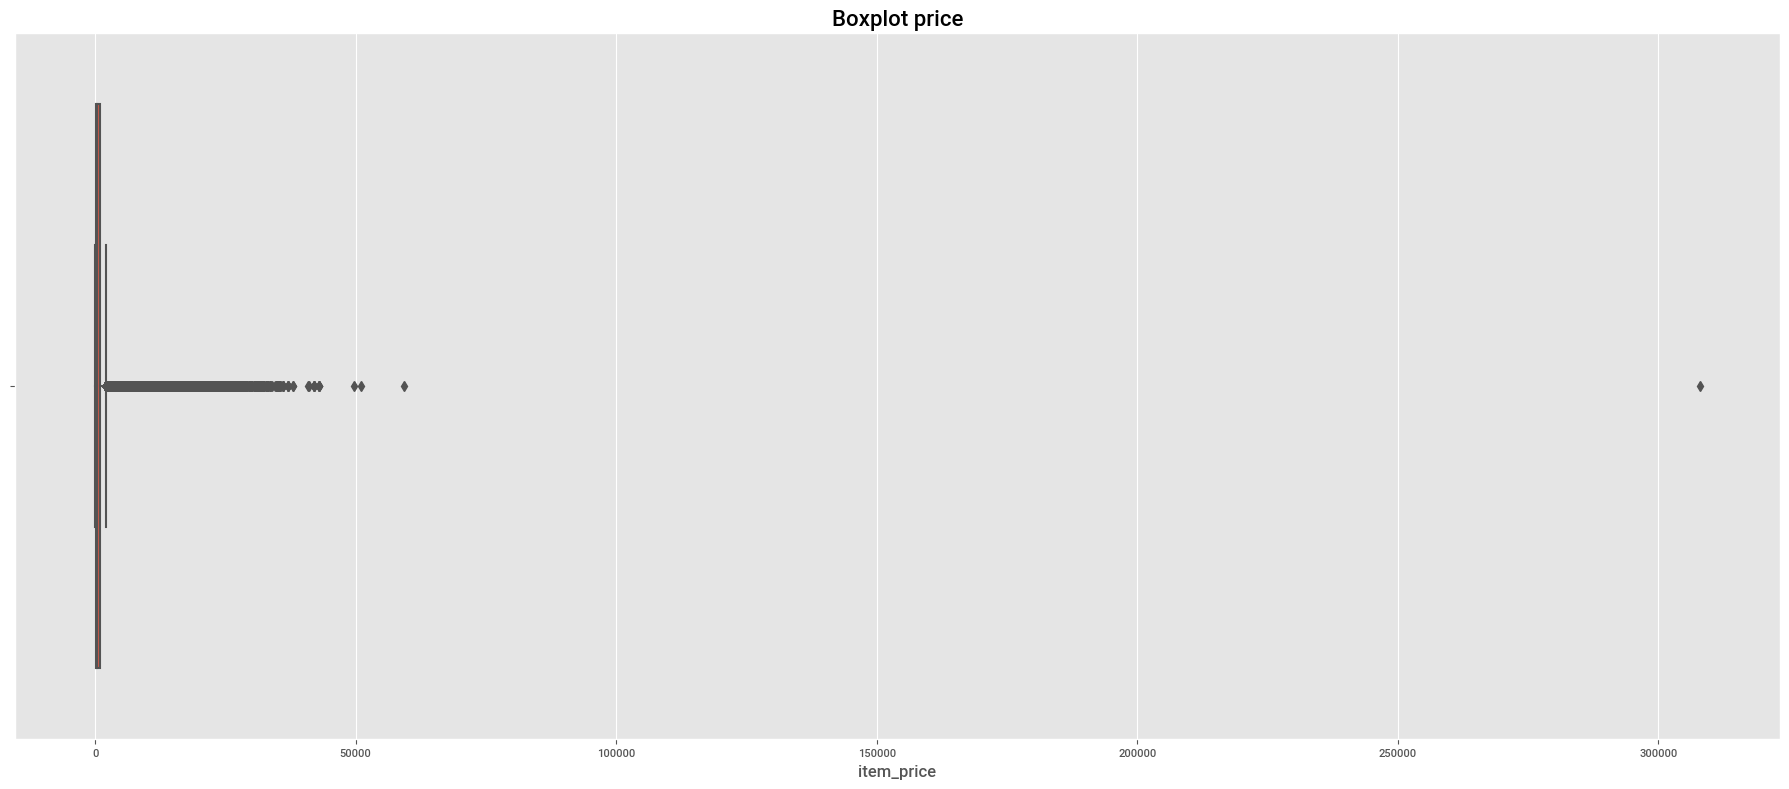

In [61]:
def print_plots(data, column, title):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
    chart = sns.boxplot(data=data, x=column)
    chart.set_title(title, fontsize=16)
    chart.set_xlabel(column)

    plt.tight_layout()
    plt.show()
    
print_plots(train_data, 'item_price', 'Boxplot price')

In [62]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
        
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    # removing outliers
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

def add_outlier(data, column, title): 
    # by price
    outliers_price, cleaned = outliers_iqr_mod(data, column, right=1.3)
    print(f'irq price outliers: {outliers_price.shape[0]}')

    if outliers_price.shape[0] > 0:
        data.loc[outliers_price.index, 'outliers'] = True
    
    print_plots(cleaned, column, title)

    print('Count of outliers: {}'.format(data[data['outliers'] == True]['outliers'].count()))

    return cleaned

In [63]:
train_data.drop(['date'], axis=1, inplace=True)

In [64]:
columns = train_data.columns

agg_arguments = {}
for col in columns:
    if col == 'item_cnt_day':
        agg_arguments[col] = 'sum'
    #if col == 'item_price': 
    #    agg_arguments[col] = 'mean',     
    elif col in ['date_block_num', 'item_id', 'shop_id']:
        pass
    else:
        agg_arguments[col] = 'first'

train_data = train_data.groupby(['item_id', 'date_block_num', 'shop_id']) \
.agg(agg_arguments) \
.reset_index() \
.rename(columns={'item_cnt_day': 'item_cnt_month'}) #, 'item_price': 'item_price_mean'})

train_data.head(3)

,item_id,date_block_num,shop_id,item_price,item_cnt_month,item_name,item_category_id,shop_name,item_category_name,month,year
0,0,20,54,58.00,1.00,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,"Химки ТЦ ""Мега""",Кино - DVD,9,2014
1,1,15,55,4490.00,2.00,!ABBYY FineReader 12 Professional Edition Full...,76,Цифровой склад 1С-Онлайн,Программы - Для дома и офиса (Цифра),4,2014
2,1,18,55,4490.00,1.00,!ABBYY FineReader 12 Professional Edition Full...,76,Цифровой склад 1С-Онлайн,Программы - Для дома и офиса (Цифра),7,2014


In [65]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608226 entries, 0 to 1608225
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   item_id             1608226 non-null  int64  
 1   date_block_num      1608226 non-null  int64  
 2   shop_id             1608226 non-null  int64  
 3   item_price          1608226 non-null  float64
 4   item_cnt_month      1608226 non-null  float64
 5   item_name           1608226 non-null  object 
 6   item_category_id    1608226 non-null  int64  
 7   shop_name           1608226 non-null  object 
 8   item_category_name  1608226 non-null  object 
 9   month               1608226 non-null  int64  
 10  year                1608226 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 135.0+ MB


ok, here we see that in data doesn't exist skips

In [66]:
train_shop_id = train_data['shop_id'].unique();
test_shop_id = test_data['shop_id'].unique();

display(train_shop_id, test_shop_id)

array([54, 55, 56, 44, 25, 31,  1,  2, 10, 19, 26, 45, 21, 15, 24, 32, 53,
       14,  5, 18,  7, 16, 27, 29,  3, 12, 28, 17,  4,  6, 35, 46, 47, 23,
       38, 43, 50, 22, 51, 41, 30, 42, 58, 59, 37,  0,  8, 13, 52, 57, 48,
       49, 39, 34, 33, 36, 40, 11,  9, 20])

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45])

In [67]:
drop_shops = train_data[~train_data['shop_id'].isin(test_shop_id)]['shop_id'].unique()
drop_shops

array([54,  1, 32, 27, 29, 17, 23, 43, 51, 30,  0,  8, 13, 33, 40, 11,  9,
       20])

In [68]:
train_categories = train_data['item_category_id'].unique();
test_categories = test_data['item_category_id'].unique();

display(train_categories, test_categories)

array([40, 76, 55, 19, 30, 23, 37, 41, 57, 43, 78, 54, 49, 44, 45, 77, 73,
       31, 75, 58, 56, 38, 67, 59, 60, 74, 21, 28, 20, 24, 29, 70, 22, 32,
       62, 25, 72,  4, 63, 27, 18, 26, 64, 15, 68,  2,  5,  1,  3,  6, 35,
       65, 14, 13, 10, 11, 12, 48, 71, 69,  7, 33, 34, 16, 66, 39, 52, 46,
       42, 61,  8, 80,  9, 17, 36, 47, 82, 81,  0, 50, 51, 79, 53, 83])

array([19, 55, 23, 20, 30, 22, 72, 35,  2,  3, 65, 24, 21, 28, 40, 70, 37,
       42, 69, 41, 67, 60, 38, 12, 31,  6, 15,  7, 29, 61, 49, 79, 64, 63,
       47, 16, 33, 25, 71, 77, 73, 56, 58, 75, 83, 62,  5, 57,  9, 45, 43,
        0, 11, 54, 76, 78, 34, 36, 27, 26, 74, 44])

In [69]:
drop_cats = train_data[~train_data['item_category_id'].isin(test_categories)]['item_category_id'].unique()
drop_cats

array([59, 32,  4, 18, 68,  1, 14, 13, 10, 48, 66, 39, 52, 46,  8, 80, 17,
       82, 81, 50, 51, 53])

In [70]:
train_data = train_data[train_data['shop_id'].isin(drop_shops)]
train_data = train_data[train_data['item_category_id'].isin(drop_cats)]

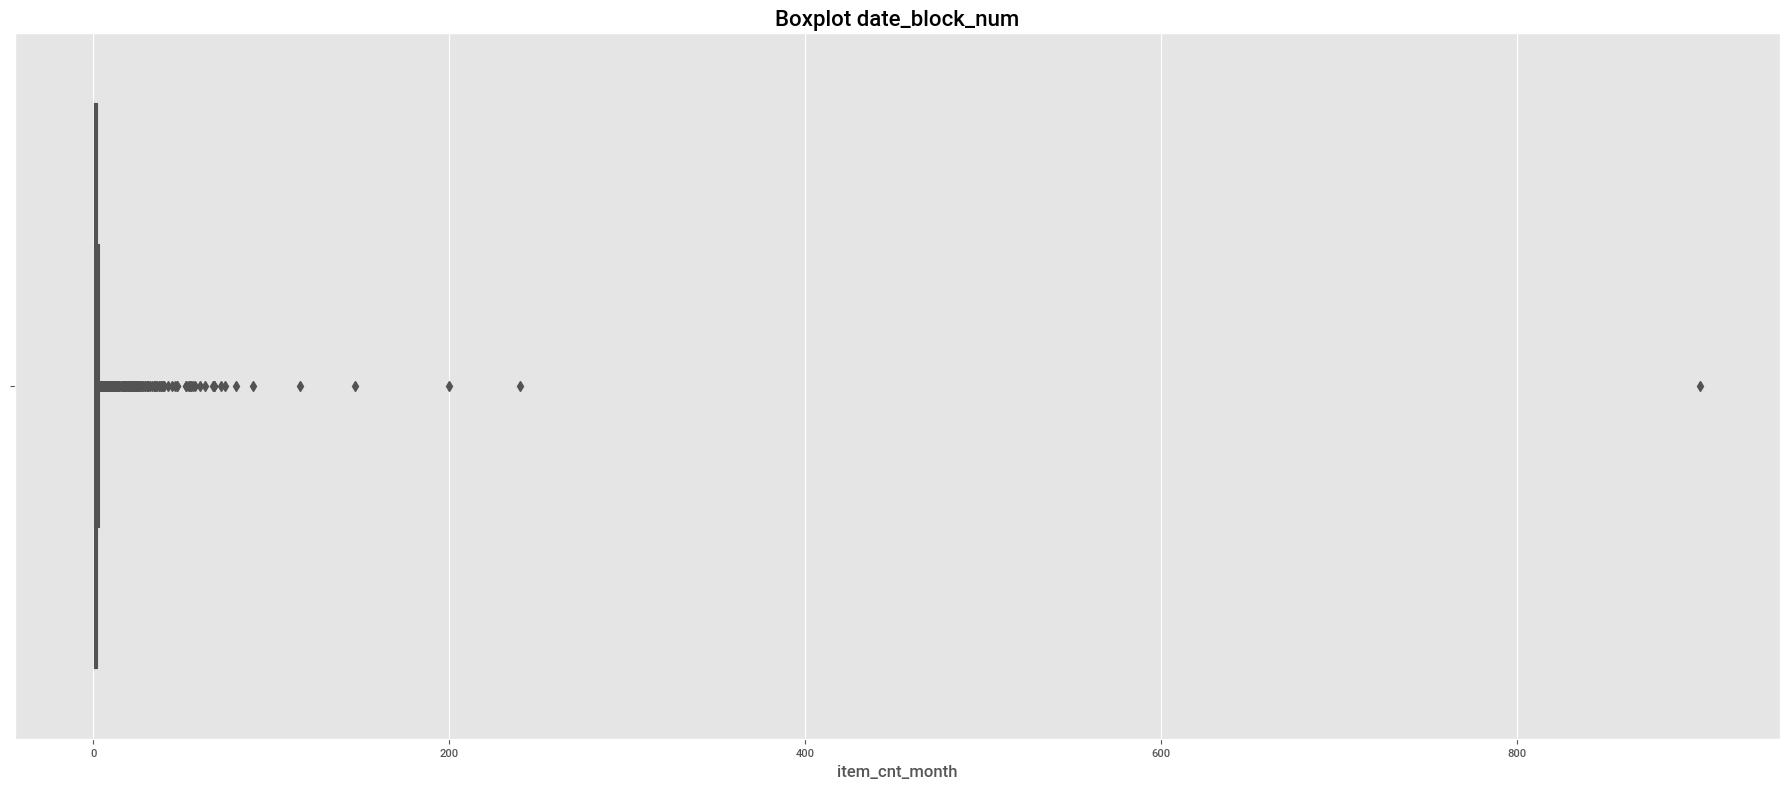

In [71]:
print_plots(train_data, 'item_cnt_month', 'Boxplot date_block_num')

Let's check allocation of item_cnt_month

irq price outliers: 420


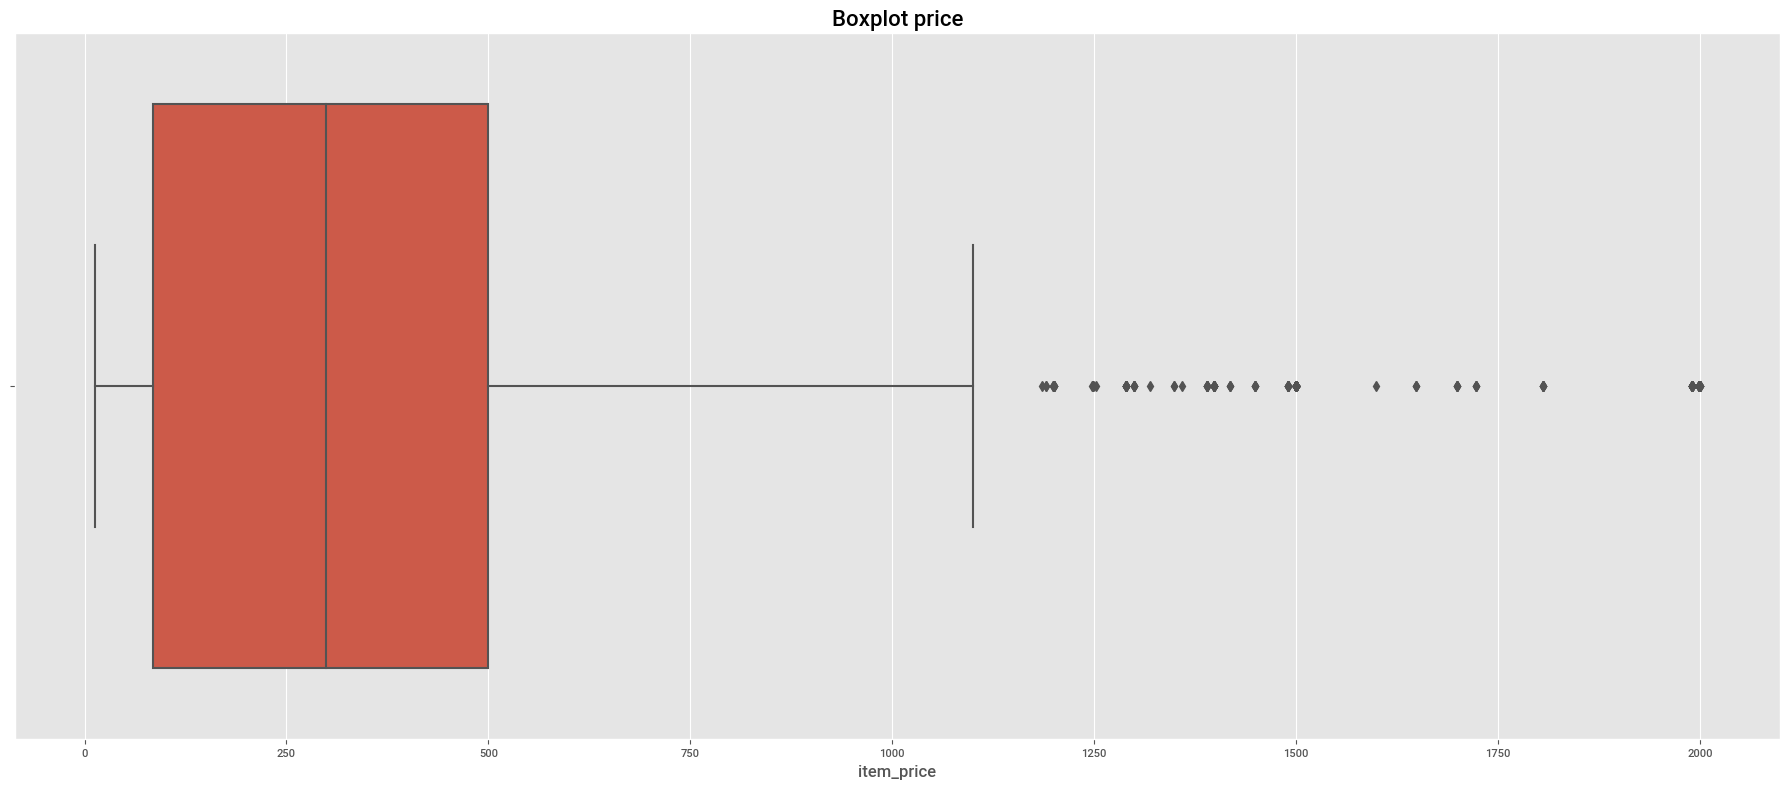

Count of outliers: 420


In [72]:
train_data = add_outlier(train_data, 'item_price', 'Boxplot price')

as we see, item_cnt_month has many outlier items, let's remove it with seeking irq otlier method

irq price outliers: 355


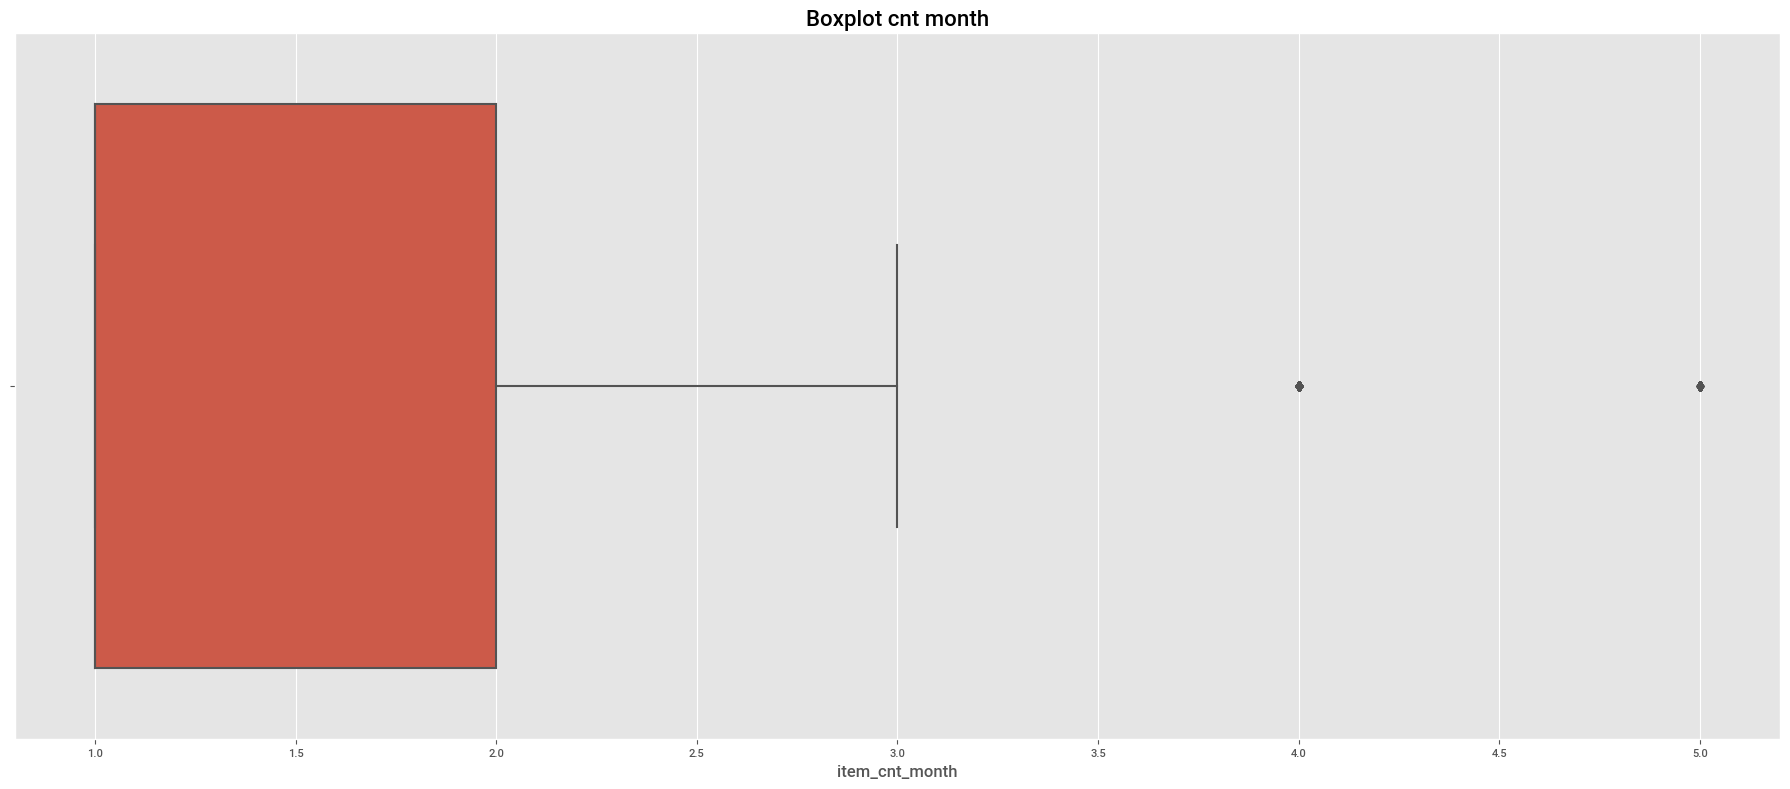

Count of outliers: 355


In [73]:
train_data = add_outlier(train_data, 'item_cnt_month', 'Boxplot cnt month')

# 2. EDA

Let's make fast eda with [library pandas-profiling](https://pandas-profiling.ydata.ai/docs/master/index.html)

                                             |          | [  0%]   00:00 -> (? left)

/Users/rbastrakov/opt/anaconda3/envs/sf/lib/python3.8/site-packages/sweetviz/utils.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clamped_series = clamped_series.append(other_series, ignore_index=False)
/Users/rbastrakov/opt/anaconda3/envs/sf/lib/python3.8/site-packages/sweetviz/utils.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clamped_series = clamped_series.append(other_series, ignore_index=False)
/Users/rbastrakov/opt/anaconda3/envs/sf/lib/python3.8/site-packages/sweetviz/graph_associations.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataframe = new_dataframe.append(pd.Series(empty_row_dict, name=feature))
/Users/rbastrakov/opt/anaconda3/envs/sf/lib/python3.8/site-packages/sweetviz/graph_as


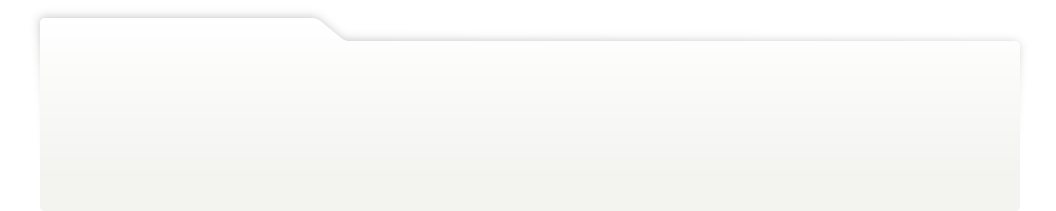
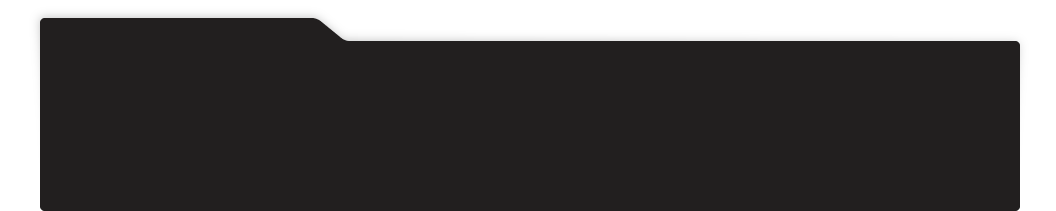
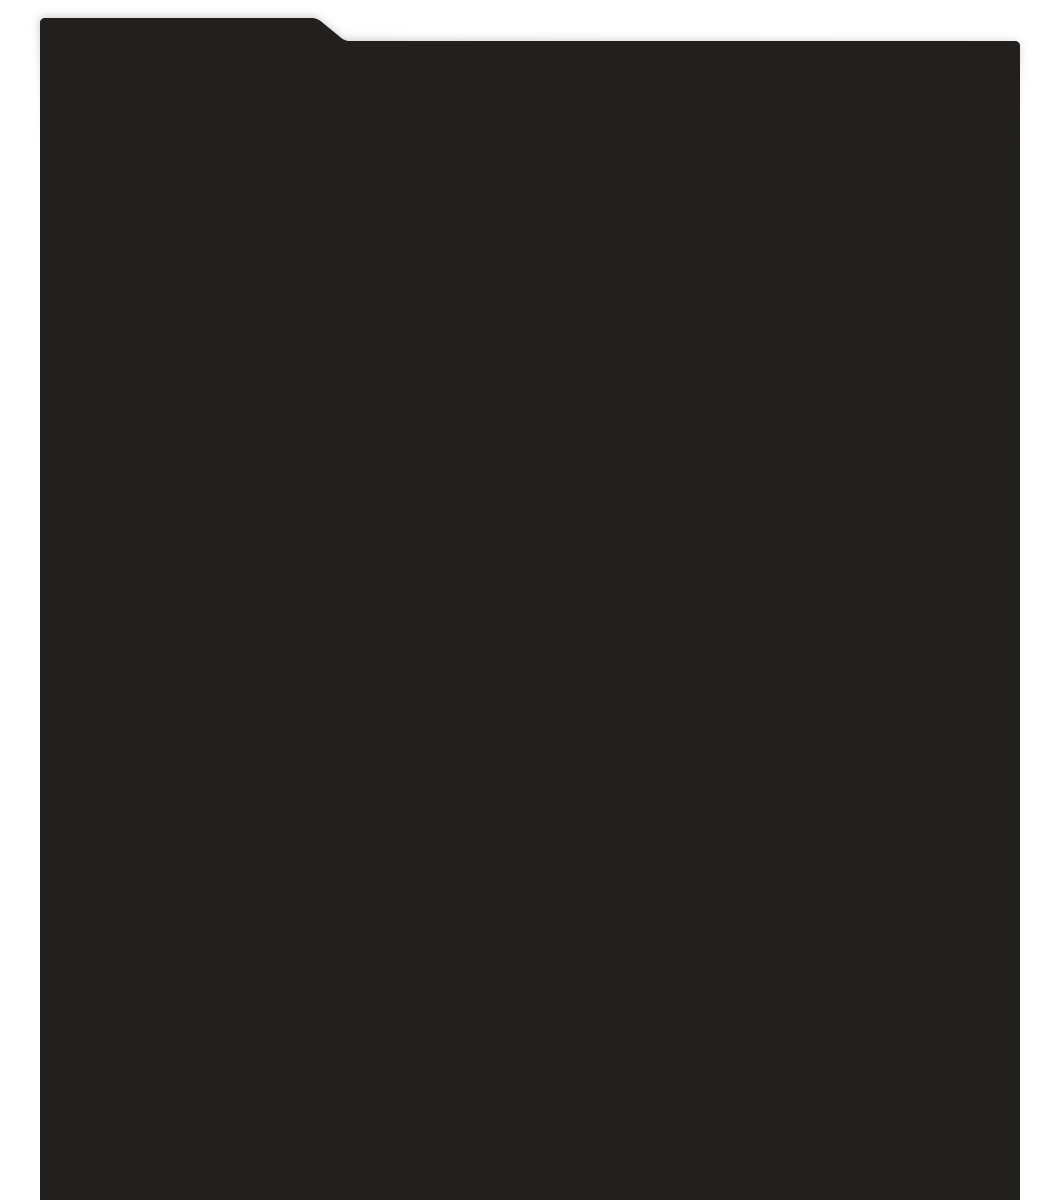
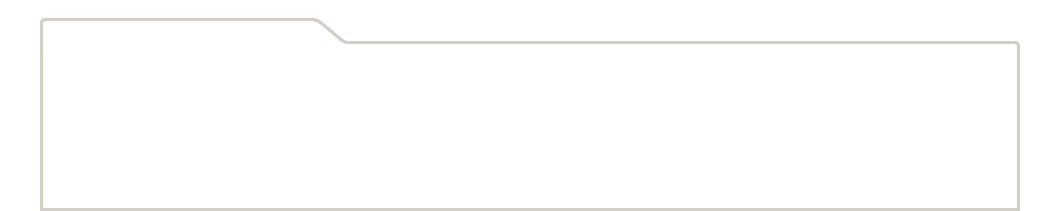
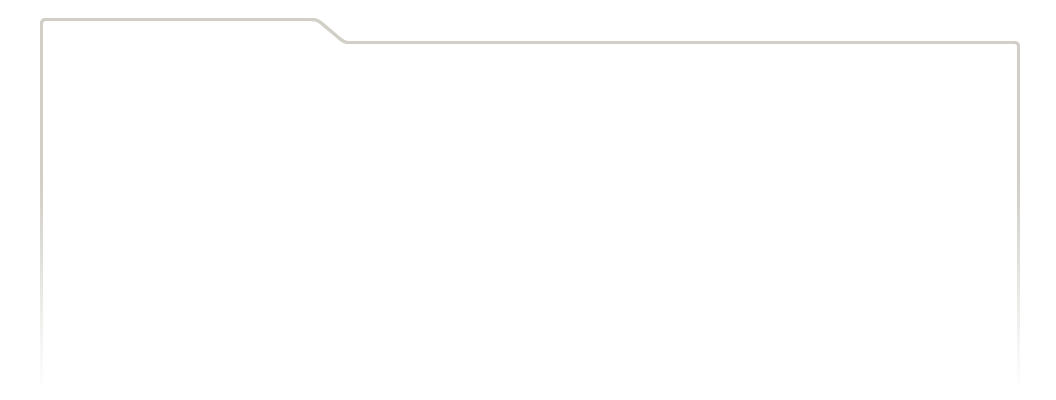
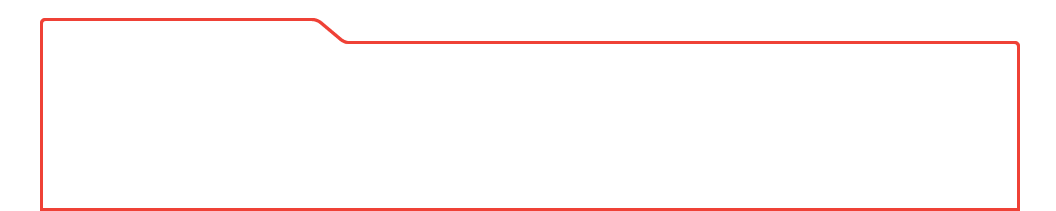
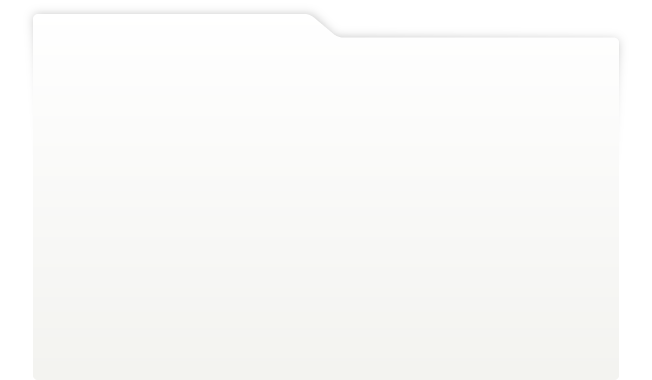
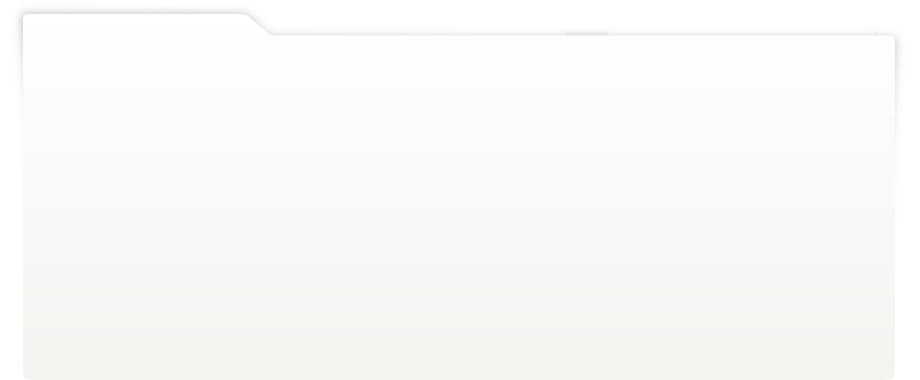
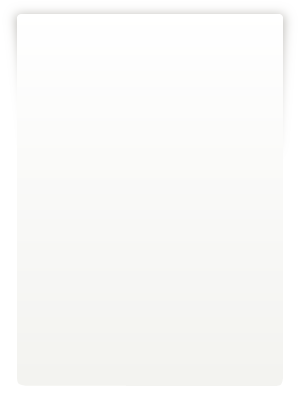
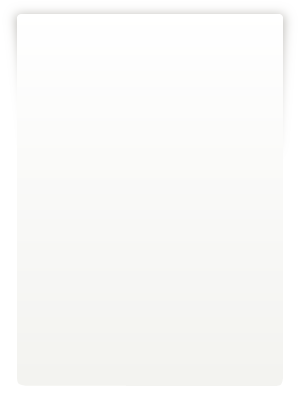
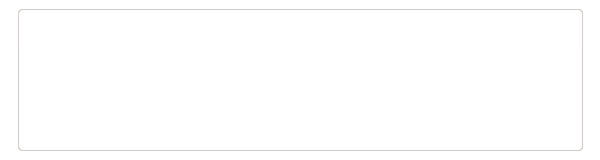
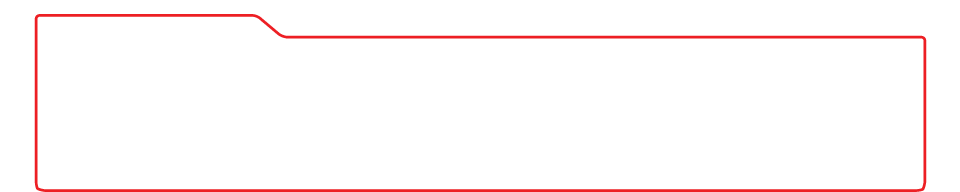
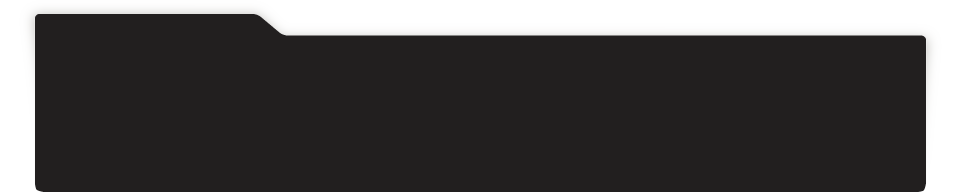
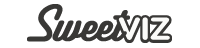
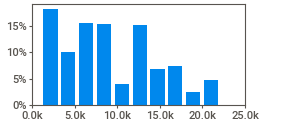
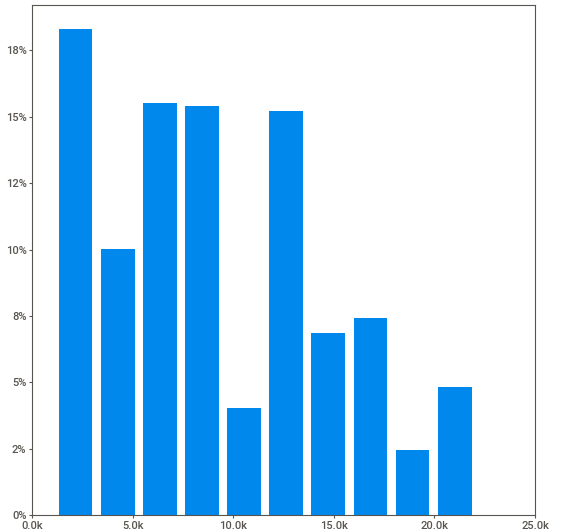
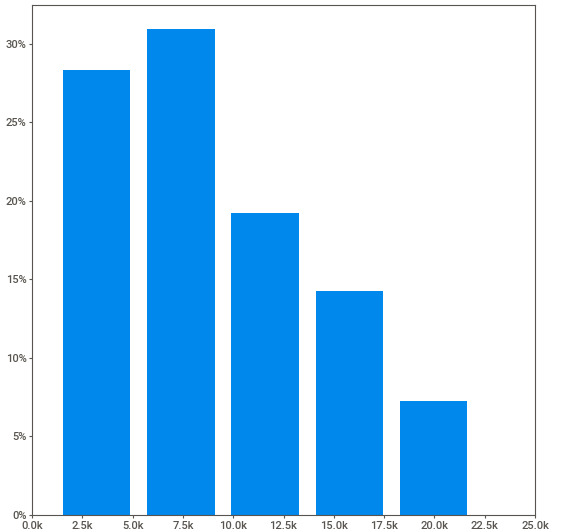
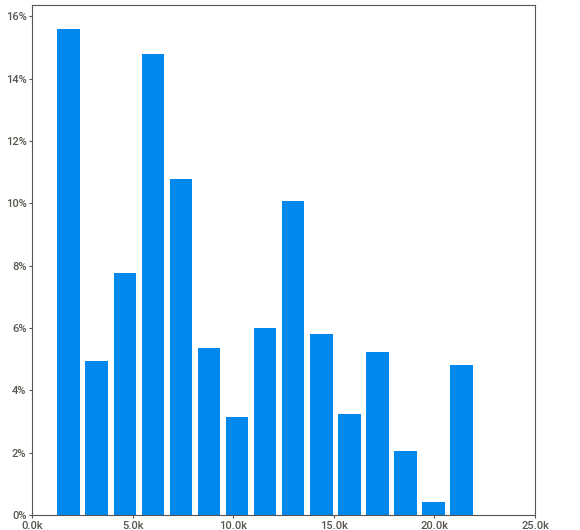
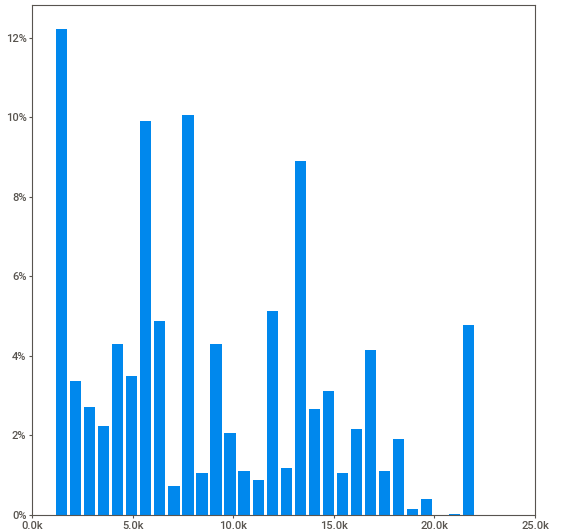
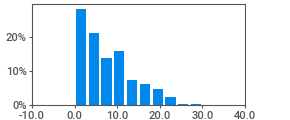
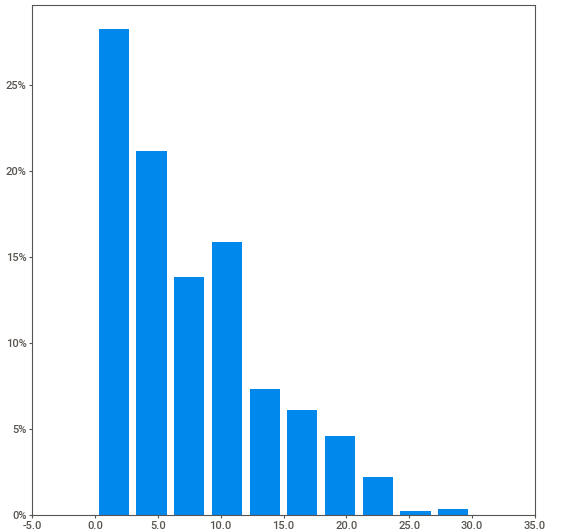
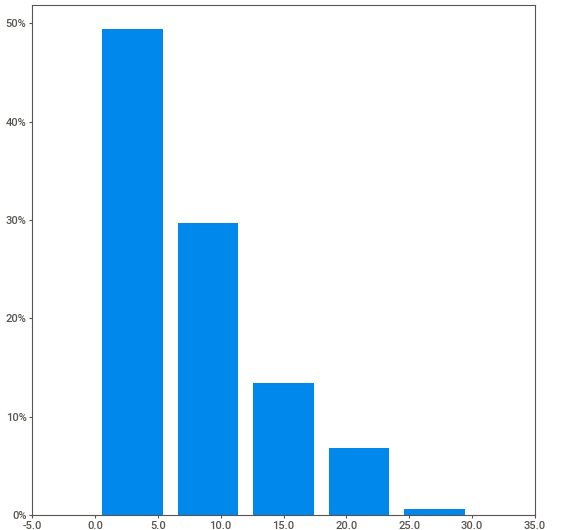
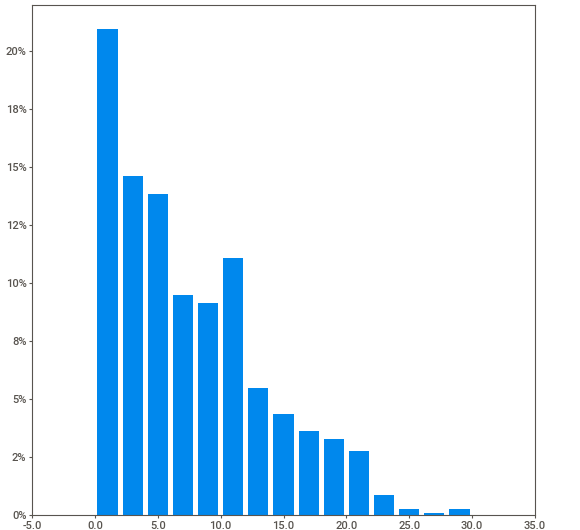
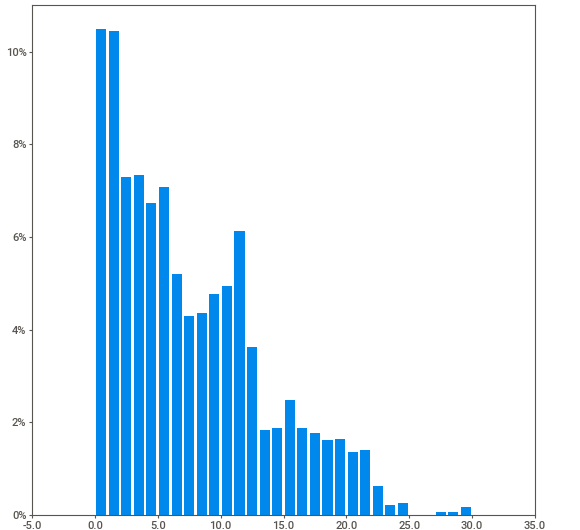
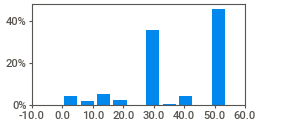
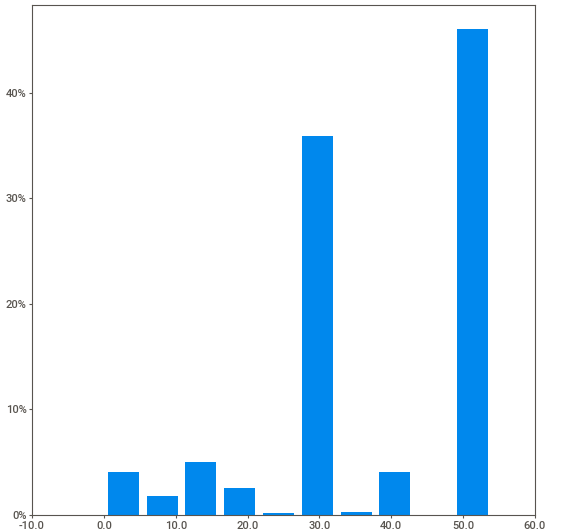
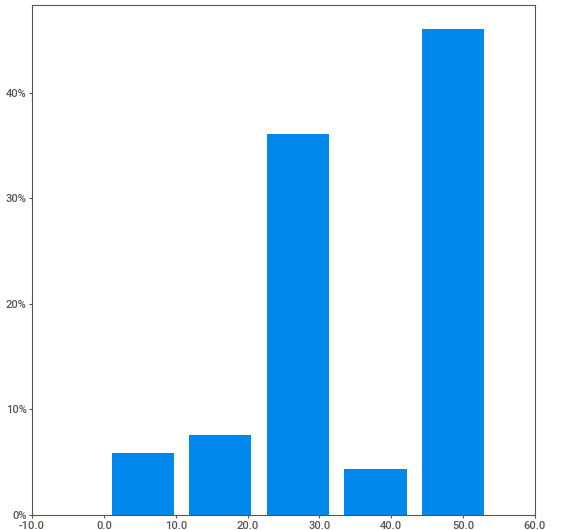
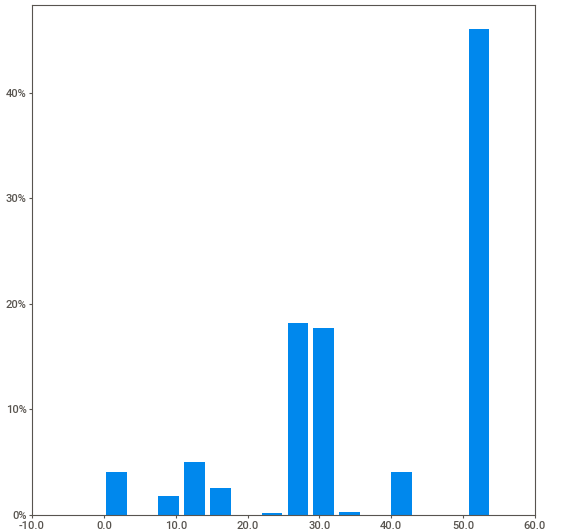
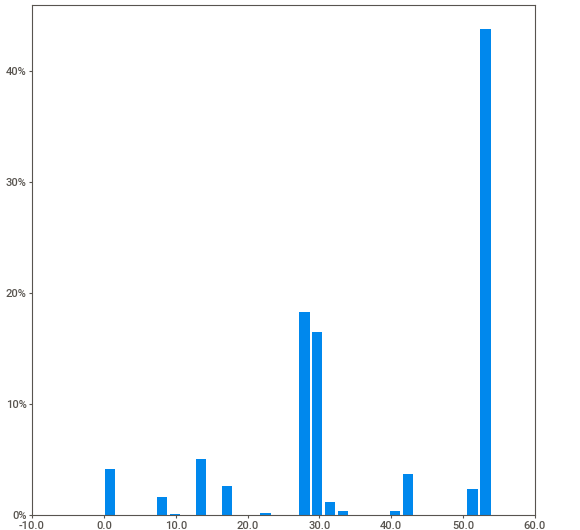
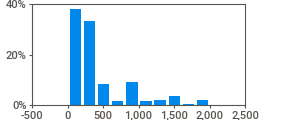
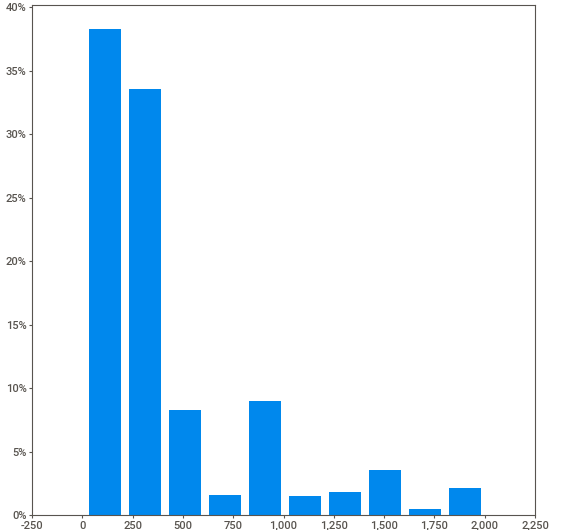
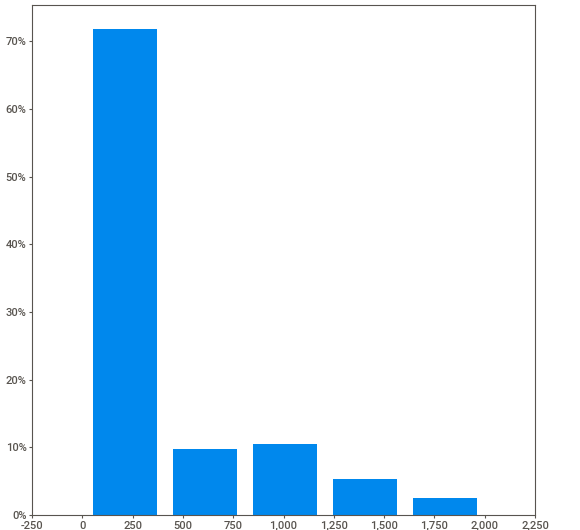
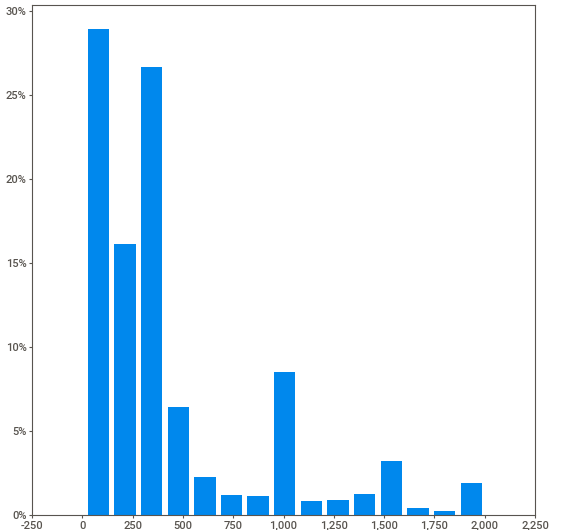
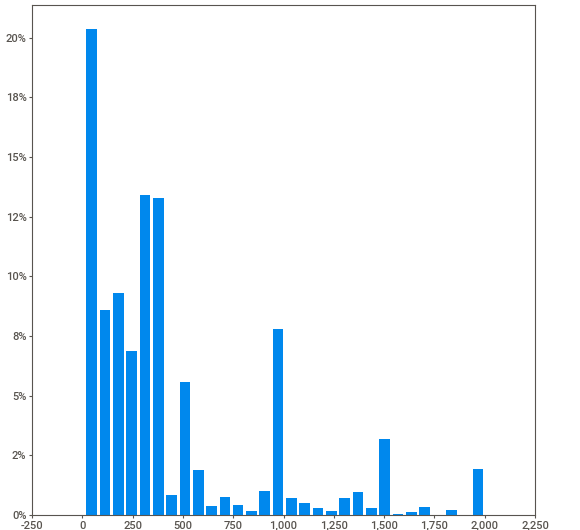
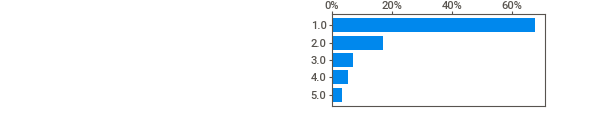
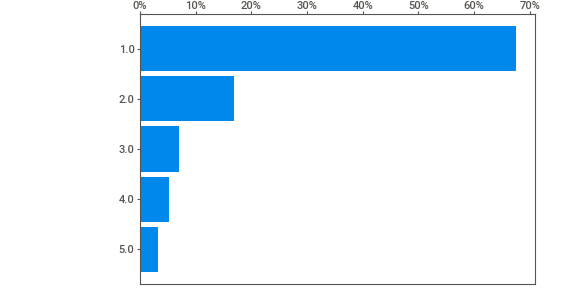
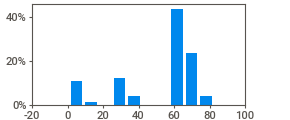
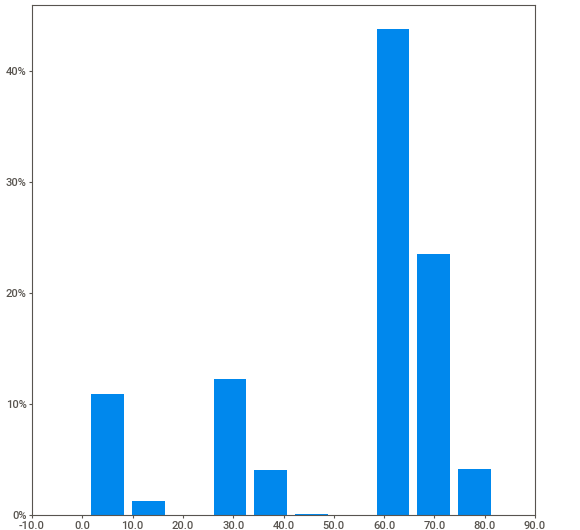
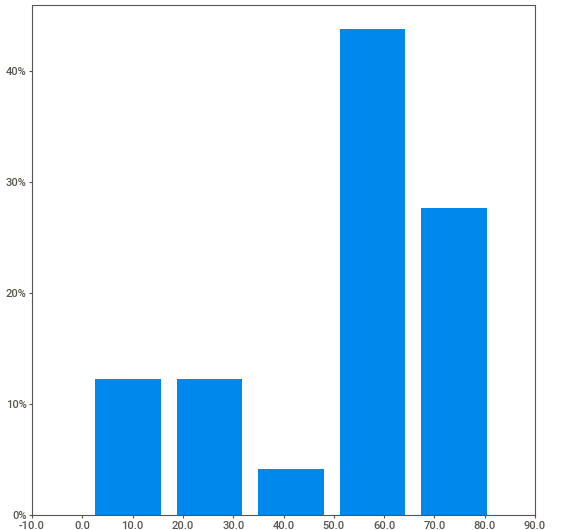
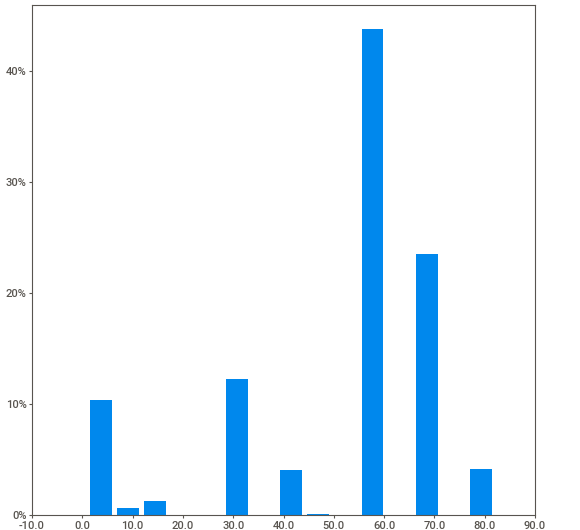
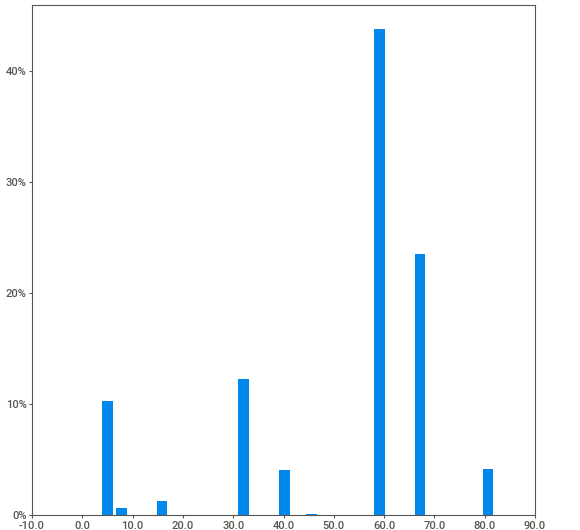
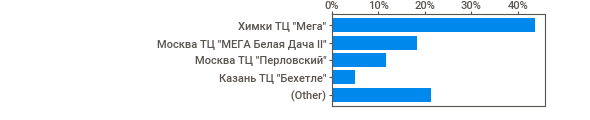
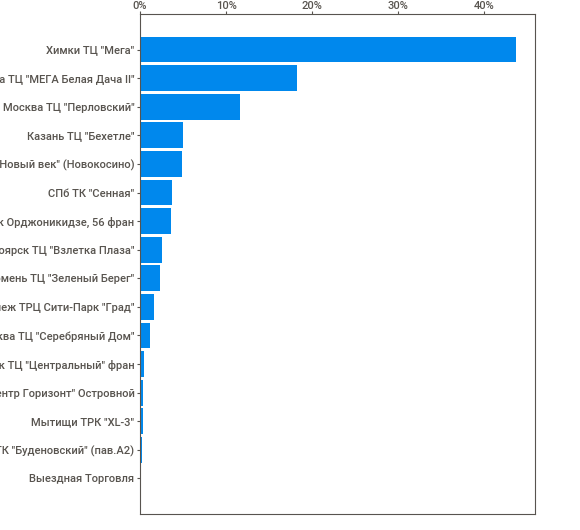
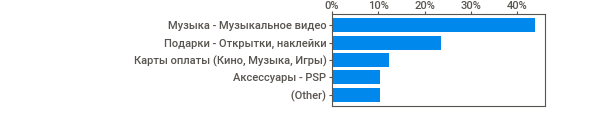
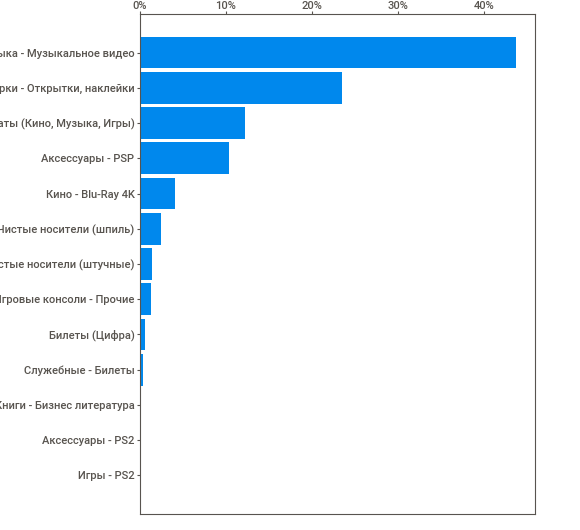
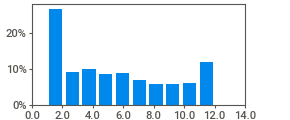
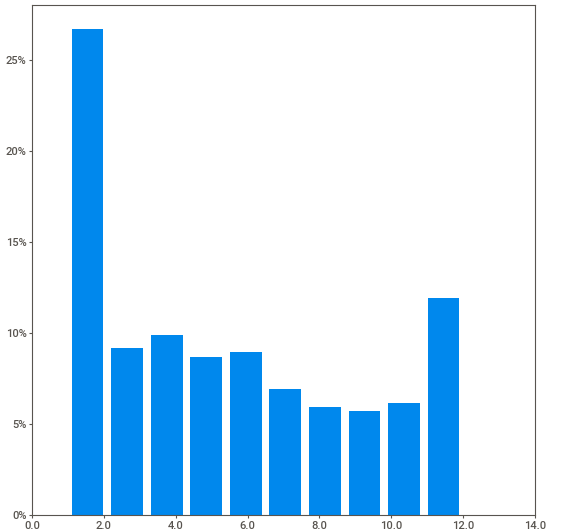
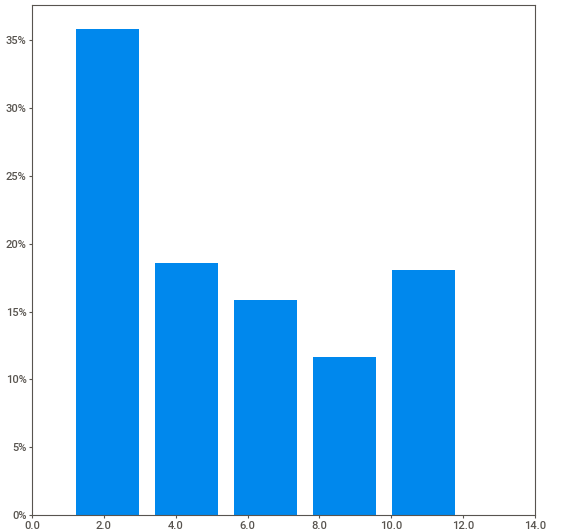
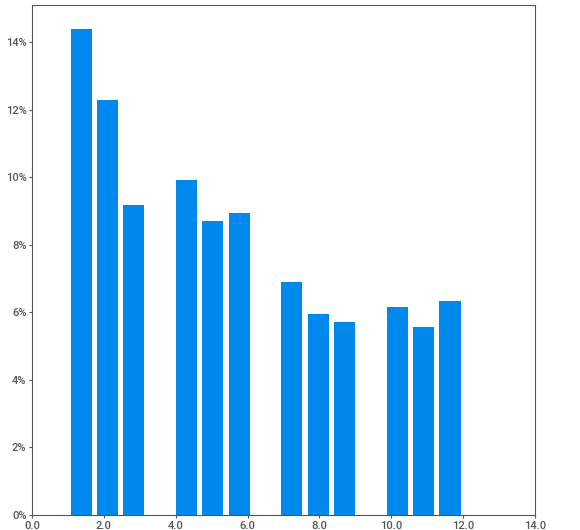
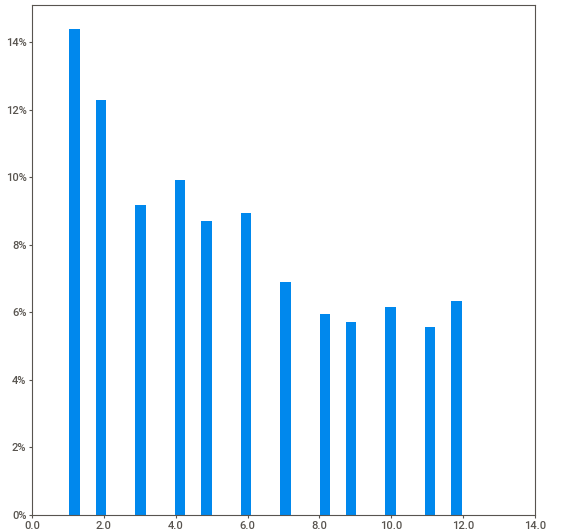
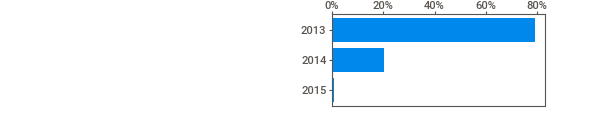
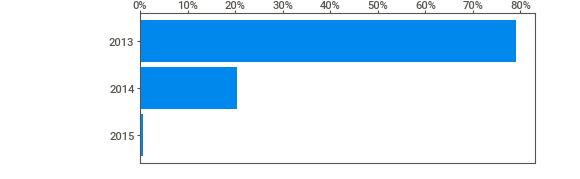
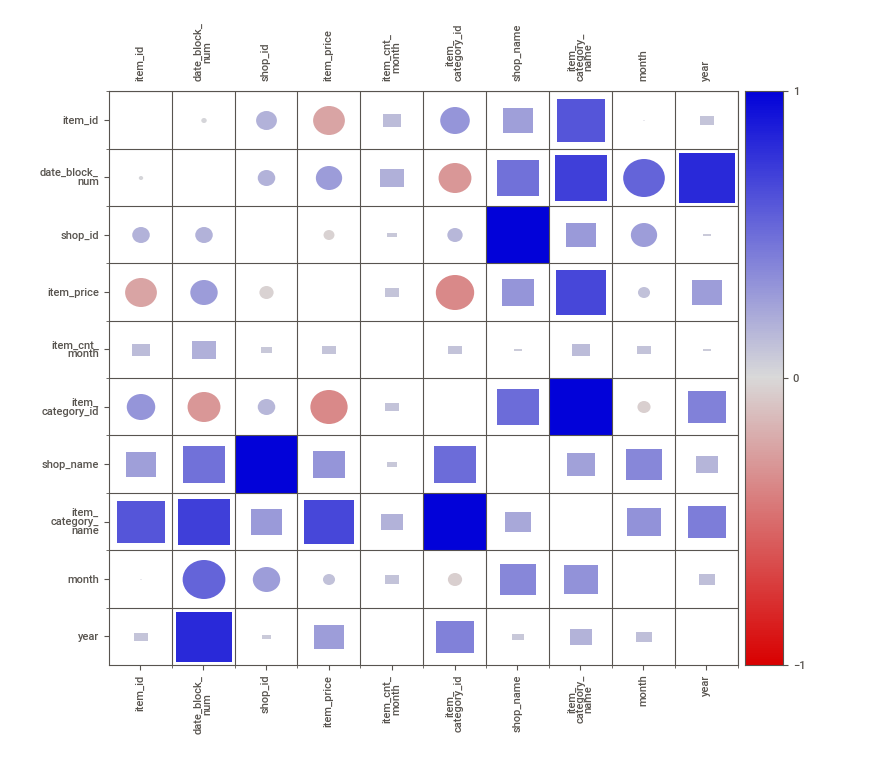
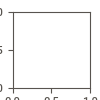

ERROR: comet_ml is installed, but not configured properly (e.g. check API key setup). HTML reports will not be uploaded.


In [74]:
report = sv.analyze(train_data)
report.show_notebook()

Lets select some new signs from 
 - category_name: we can select few categories
 - shop_name we can select city
 - item_name we can select carrier type

In [75]:
train_data['item_category_name'].unique()

array(['Музыка - Музыкальное видео', 'Карты оплаты (Кино, Музыка, Игры)',
       'Аксессуары - PSP', 'Аксессуары - PS2', 'Игры - PS2',
       'Подарки - Открытки, наклейки', 'Кино - Blu-Ray 4K',
       'Билеты (Цифра)', 'Служебные - Билеты',
       'Книги - Бизнес литература', 'Игровые консоли - Прочие',
       'Чистые носители (штучные)', 'Чистые носители (шпиль)'],
      dtype=object)

In [76]:
train_data['shop_name'].unique()

array(['Химки ТЦ "Мега"', 'Москва ТЦ "Перловский"',
       '!Якутск Орджоникидзе, 56 фран', 'Воронеж ТРЦ Сити-Парк "Град"',
       'Москва ТЦ "МЕГА Белая Дача II"', 'Казань ТЦ "Бехетле"',
       'СПб ТК "Сенная"', 'Москва ТЦ "Новый век" (Новокосино)',
       'Красноярск ТЦ "Взлетка Плаза"', 'Выездная Торговля',
       'Мытищи ТРК "XL-3"',
       'РостовНаДону ТРК "Мегацентр Горизонт" Островной',
       '!Якутск ТЦ "Центральный" фран', 'Москва ТЦ "Серебряный Дом"',
       'Тюмень ТЦ "Зеленый Берег"', 'Москва ТК "Буденовский" (пав.А2)'],
      dtype=object)

In [77]:
def get_cat(item):
    cats = item.split(' - ')
    
    return cats[0]
    
def get_subcat(item):
    cats = item.split(' - ')
    
    if 'Билеты (Цифра)' == cats[0]:
        return 'Билеты'
    
    if len(cats) < 2: 
        return 'Прочие'
        
    if 'Цифра' in cats[1]:
        return 'digit'
    
    if 'Live!' in cats[1]:
        return 'Прочие'
    
    return cats[1]

train_data['category'] = train_data['item_category_name'].apply(get_cat)
train_data['subcategory'] = train_data['item_category_name'].apply(get_subcat)

test_data['category'] = test_data['item_category_name'].apply(get_cat)
test_data['subcategory'] = test_data['item_category_name'].apply(get_subcat)


In [78]:
def get_city(item):
    if 'Цифровой' in item or 'Интернет-магазин' in item:
        return 'digital'
    
    name = item.split(' ')
    name = re.sub(r'(?u)[^\w]+', '', name[0])
    
    if name == 'РостовНаДону':
        return 'Ростов-на-Дону'
    if name == 'СПб':
        return 'Санкт-Петербург'
    if name == 'ННовгород':
        return 'Нижний Новгород'
    if name == 'Сергиев':
        return 'Сергиев Посад'
    
    return name
    
train_data['city'] = train_data['shop_name'].apply(get_city)
test_data['city'] = test_data['shop_name'].apply(get_city)


In [79]:
city_info = pd.read_csv(INPUT_DIR + 'cityinfo/data.csv')

In [80]:
print(train_data.shape[0], test_data.shape[0])
test_data['city'].unique()

2727 214200


array(['Вологда', 'Волжский', 'Воронеж', 'Балашиха', 'Адыгея',
       'Жуковский', 'digital', 'Москва', 'Калуга', 'Коломна',
       'Красноярск', 'Казань', 'Курск', 'Санкт-Петербург', 'Тюмень',
       'Уфа', 'Сургут', 'Томск', 'Якутск', 'Ярославль', 'Чехов',
       'Новосибирск', 'Нижний Новгород', 'Омск', 'Сергиев Посад',
       'Ростов-на-Дону', 'Самара'], dtype=object)

In [81]:
cities = set(list(test_data['city'].unique()) + list(train_data['city'].unique()))

In [82]:
def get_city_info(sn):
    
    if sn == 'Уфа':
        conditions = (city_info['municipality'] == sn) & (city_info['type'] == 'р-н')
    elif sn == 'Адыгея':
        conditions = (city_info['region'] == 'Республика Адыгея')
    else:
        conditions = (city_info['settlement'] == sn)

    cities_info = city_info[conditions]
    population = cities_info.groupby('region').agg({'population': 'sum'}).reset_index()['population'].max()
    
    return population
    
cities_sizes = {}
for city in cities:
    cities_sizes[city] = get_city_info(city)
    
cities_sizes

{'Якутск': 318768,
 'digital': nan,
 'Балашиха': 215494,
 'Волжский': 326841,
 'Курск': 449556,
 'Казань': 1205651,
 'Самара': 1156608,
 'Сургут': 373940,
 'Химки': 207425,
 'Ростов-на-Дону': 1125299,
 'Воронеж': 1054111,
 'Новосибирск': 1618039,
 'Нижний Новгород': 1276560,
 'Жуковский': 104736,
 'Чехов': 60720,
 'Сергиев Посад': 111179,
 'Москва': 12380664,
 'Адыгея': 643511,
 'Коломна': 144589,
 'Калуга': 335017,
 'Красноярск': 1066934,
 'Вологда': 311166,
 'Санкт-Петербург': 5225690,
 'Тюмень': 744554,
 'Уфа': 1096702,
 'Томск': 575352,
 'Ярославль': 603961,
 'Омск': 1178391,
 'Выездная': nan,
 'Мытищи': 173160}

In [83]:
def set_city_info(data):
    data['city_size'] = data['city'].apply(lambda x: cities_sizes[x])
    mean_size = data[(data['city'] != 'Москва') & (data['city'] != 'Санкт-Петербург')]['city_size'].mean()
    data['city_size'] = data['city_size'].fillna(mean_size)
    return data

train_data = set_city_info(train_data)
test_data = set_city_info(test_data)

train_data.head(3)

,item_id,date_block_num,shop_id,item_price,item_cnt_month,item_name,item_category_id,shop_name,item_category_name,month,year,category,subcategory,city,city_size
42991,1123,2,54,349.00,2.00,A-HA Ending On A High Note The Final Concert...,59,"Химки ТЦ ""Мега""",Музыка - Музыкальное видео,3,2013,Музыка,Музыкальное видео,Химки,207425.00
42996,1123,4,30,349.00,1.00,A-HA Ending On A High Note The Final Concert...,59,"Москва ТЦ ""Перловский""",Музыка - Музыкальное видео,5,2013,Музыка,Музыкальное видео,Москва,12380664.00
42999,1123,5,54,349.00,1.00,A-HA Ending On A High Note The Final Concert...,59,"Химки ТЦ ""Мега""",Музыка - Музыкальное видео,6,2013,Музыка,Музыкальное видео,Химки,207425.00


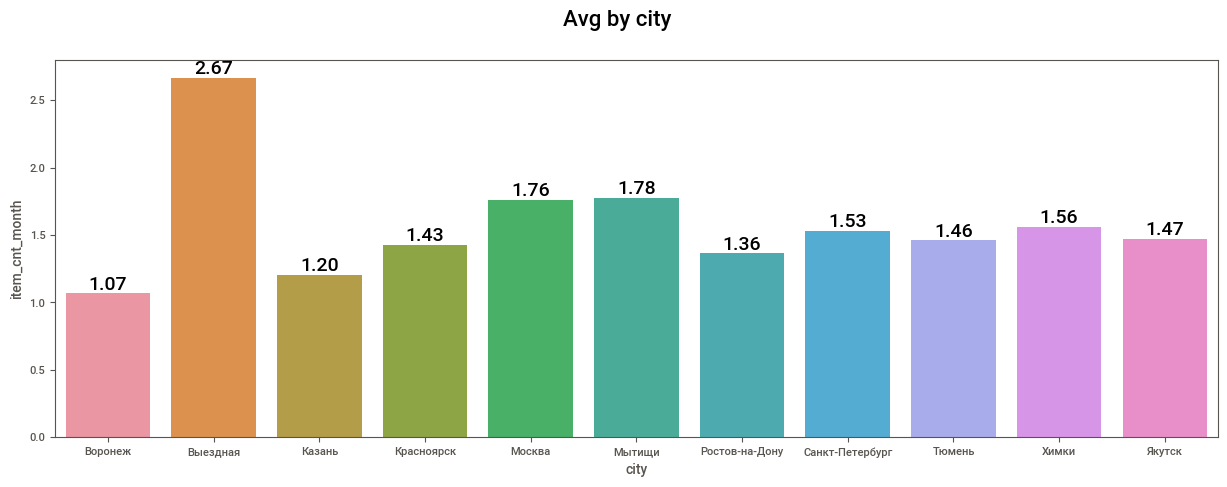

In [84]:
def avg_chart(data, column, title, dest_column = 'item_cnt_month'):
    pivotdata = data[[column, dest_column]].groupby(column).mean()
    fig5, ax5 = plt.subplots(figsize=(15, 5))
    plt.suptitle(title, size=16)
    bar_pivot = sns.barplot(
        x=pivotdata.index, 
        y=pivotdata[dest_column])

    for p in bar_pivot.patches:
        bar_pivot.annotate('{:.2f}'.format(p.get_height()), 
                           (p.get_x()+0.4, p.get_height()),
                           ha='center', va='bottom', fontsize=14)


avg_chart(train_data, 'city', 'Avg by city')

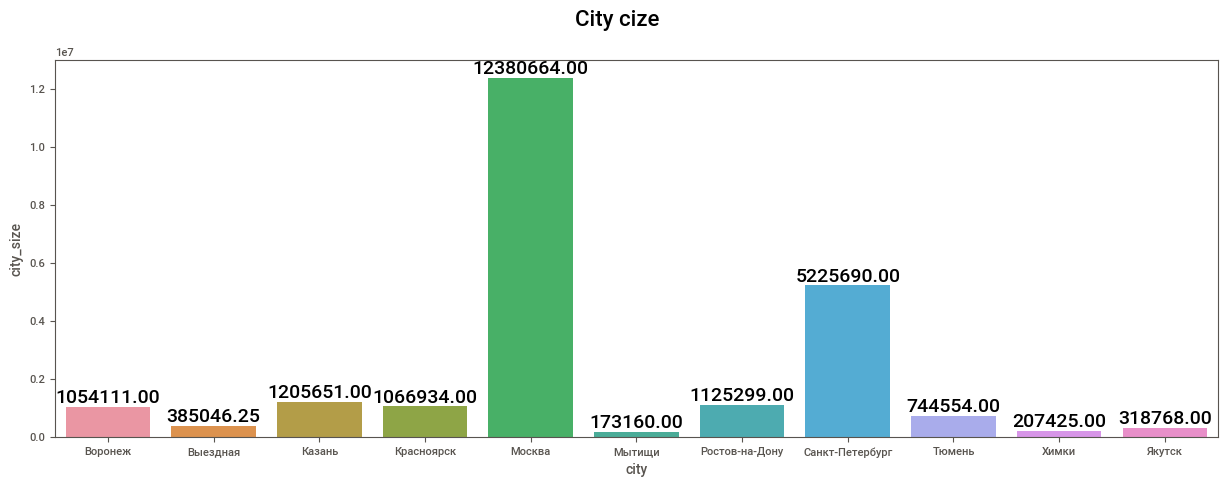

In [85]:
avg_chart(train_data, 'city', 'City cize', 'city_size')

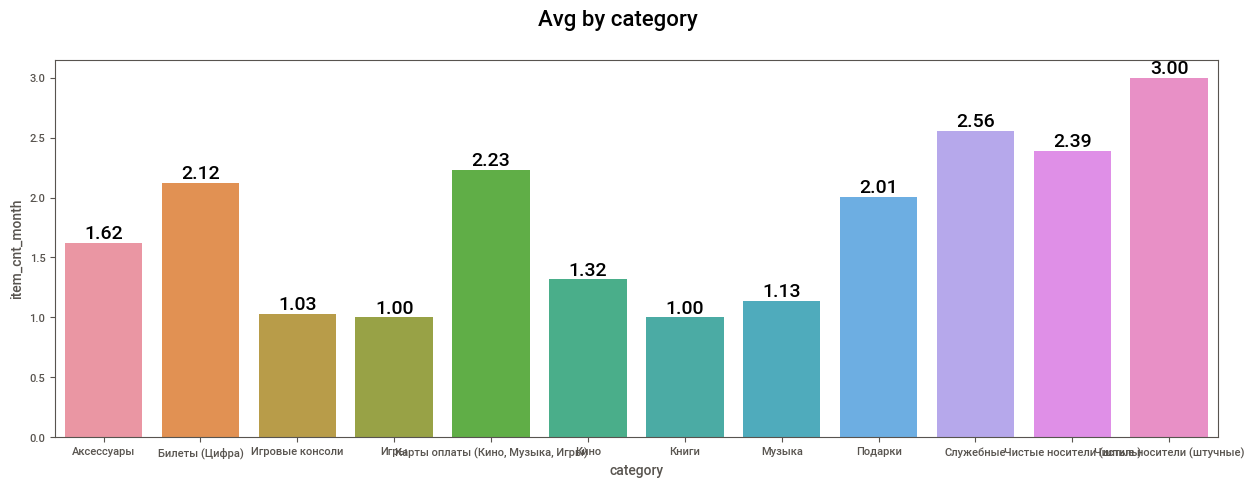

In [86]:
avg_chart(train_data, 'category', 'Avg by category')

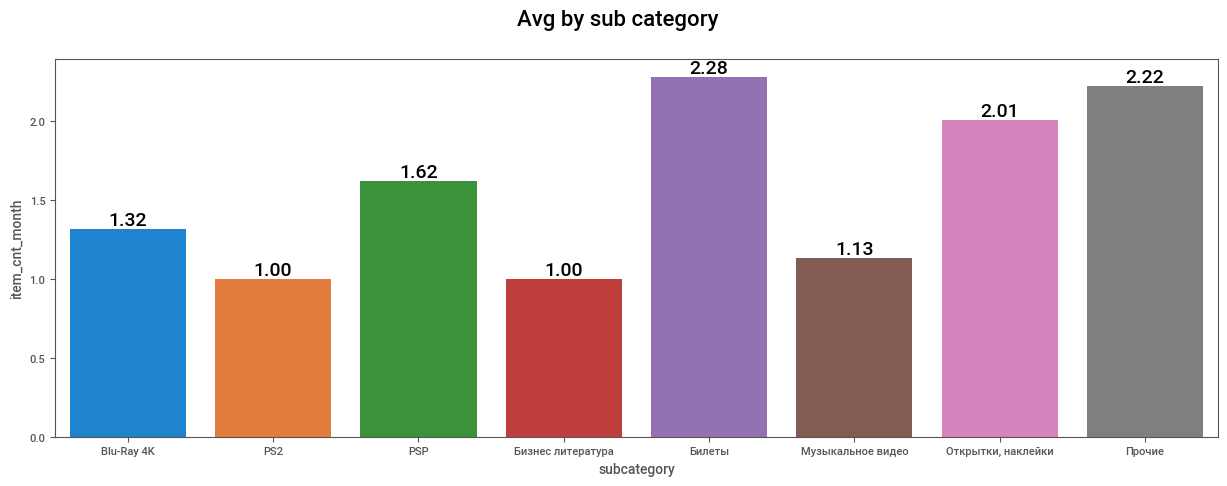

In [87]:
avg_chart(train_data, 'subcategory', 'Avg by sub category')

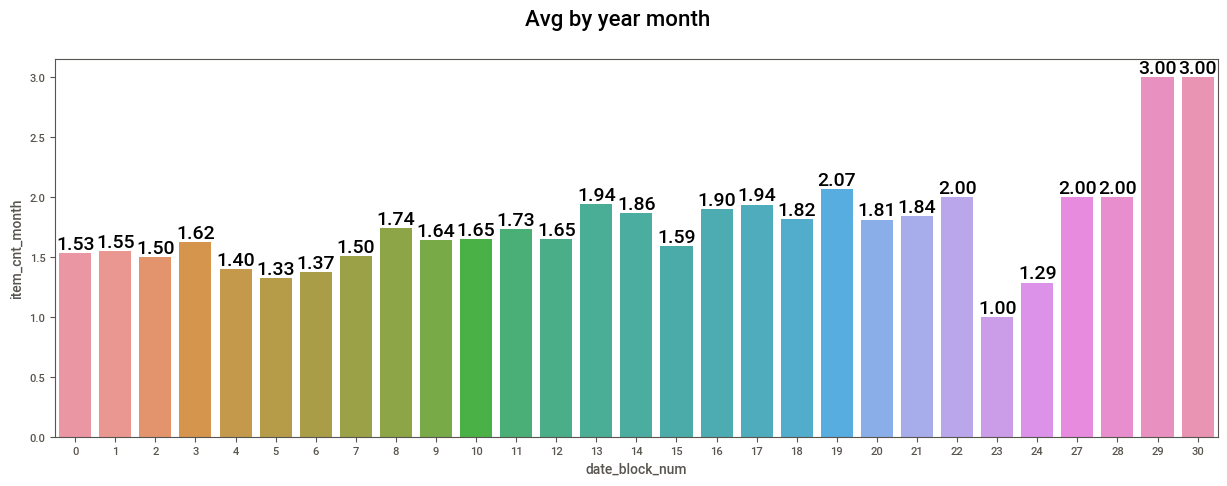

In [88]:
avg_chart(train_data, 'date_block_num', 'Avg by year month')

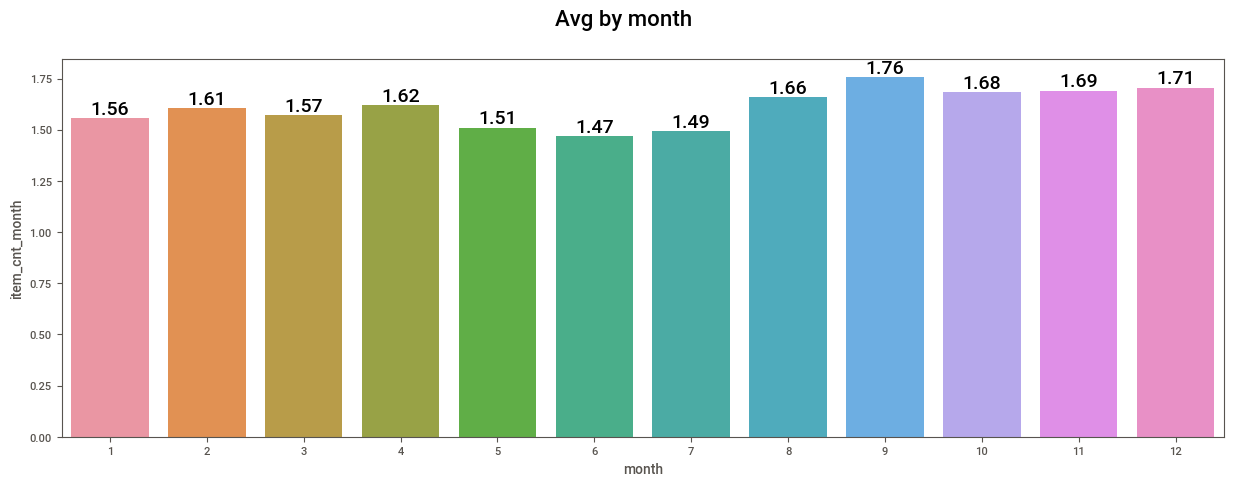

In [89]:
avg_chart(train_data, 'month', 'Avg by month')

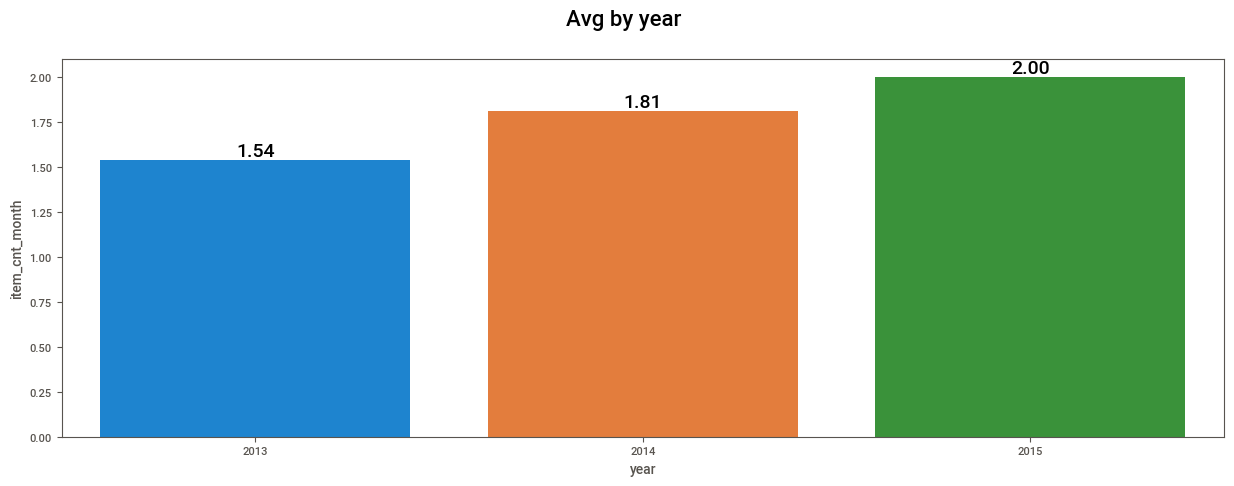

In [90]:
avg_chart(train_data, 'year', 'Avg by year')

lets encode signs

In [91]:
import category_encoders as ce

def bin_encoding(data, column):
    encoder = ce.BinaryEncoder(cols=[column])
    encoded = encoder.fit_transform(data[column])
    return pd.concat([data, encoded], axis=1)
    
def ord_encoding(data, column):
    ord_encoder = ce.OrdinalEncoder(cols=[column])
    data[column + '_cat'] = ord_encoder.fit_transform(data[column])
    return data

train_data = bin_encoding(train_data, 'category')
test_data = bin_encoding(test_data, 'category')

train_data = bin_encoding(train_data, 'subcategory')
test_data = bin_encoding(test_data, 'subcategory')

train_data = bin_encoding(train_data, 'city')
test_data = bin_encoding(test_data, 'city')

train_data = ord_encoding(train_data, 'item_name')
test_data = ord_encoding(test_data, 'item_name')

drop_columns = ['category', 'subcategory', 'item_category_name', 'city', 'item_name', 'shop_name'];
test_data.drop(drop_columns, axis = 1, inplace=True)

In [92]:
train_data.drop(['category', 'subcategory', 'item_category_name', 'city', 'item_name', 'shop_name'], axis = 1, inplace=True)

In [93]:
train_data.columns

Index(['item_id', 'date_block_num', 'shop_id', 'item_price', 'item_cnt_month',
       'item_category_id', 'month', 'year', 'city_size', 'category_0',
       'category_1', 'category_2', 'category_3', 'subcategory_0',
       'subcategory_1', 'subcategory_2', 'subcategory_3', 'city_0', 'city_1',
       'city_2', 'city_3', 'item_name_cat'],
      dtype='object')

## Normalizing

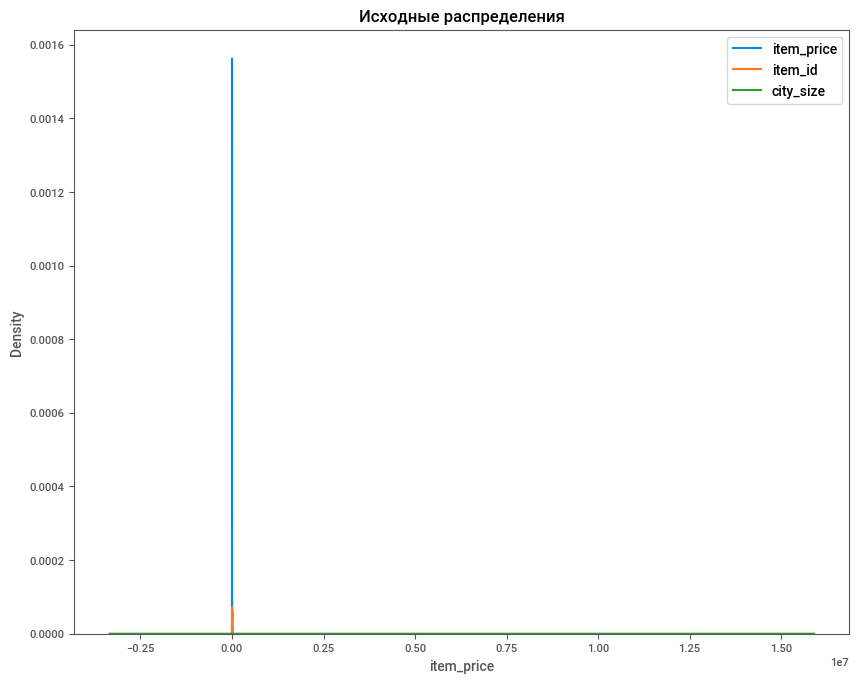

In [94]:
num_columns = [
    'item_price', 
    'item_id',
    'city_size'
]

def normal_chart(data, columns):
    fig = plt.figure(figsize=(10, 8))

    for col in columns:
        kde = sns.kdeplot(data[col], label =col)

    kde.set_title('Исходные распределения')
    plt.legend();

normal_chart(train_data, num_columns)

In [95]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   shop_id           214200 non-null  int64  
 1   item_id           214200 non-null  int64  
 2   item_category_id  214200 non-null  int64  
 3   item_price        214200 non-null  float64
 4   date_block_num    214200 non-null  int64  
 5   month             214200 non-null  int64  
 6   year              214200 non-null  int64  
 7   city_size         214200 non-null  float64
 8   category_0        214200 non-null  int64  
 9   category_1        214200 non-null  int64  
 10  category_2        214200 non-null  int64  
 11  category_3        214200 non-null  int64  
 12  category_4        214200 non-null  int64  
 13  subcategory_0     214200 non-null  int64  
 14  subcategory_1     214200 non-null  int64  
 15  subcategory_2     214200 non-null  int64  
 16  subcategory_3     21

In [96]:

from sklearn.preprocessing import RobustScaler

def normalizing(data, columns):
    
    trans = MinMaxScaler()
    for col in columns:
        df = pd.DataFrame(data[col])
        data[col + '_norm'] = trans.fit_transform(df)
        data[col + '_norm'] = data[col + '_norm'].fillna(0)
        
    return data

train_data = normalizing(train_data, ['item_id', 'item_price', 'city_size'])
test_data = normalizing(test_data, ['item_id', 'item_price', 'city_size'])

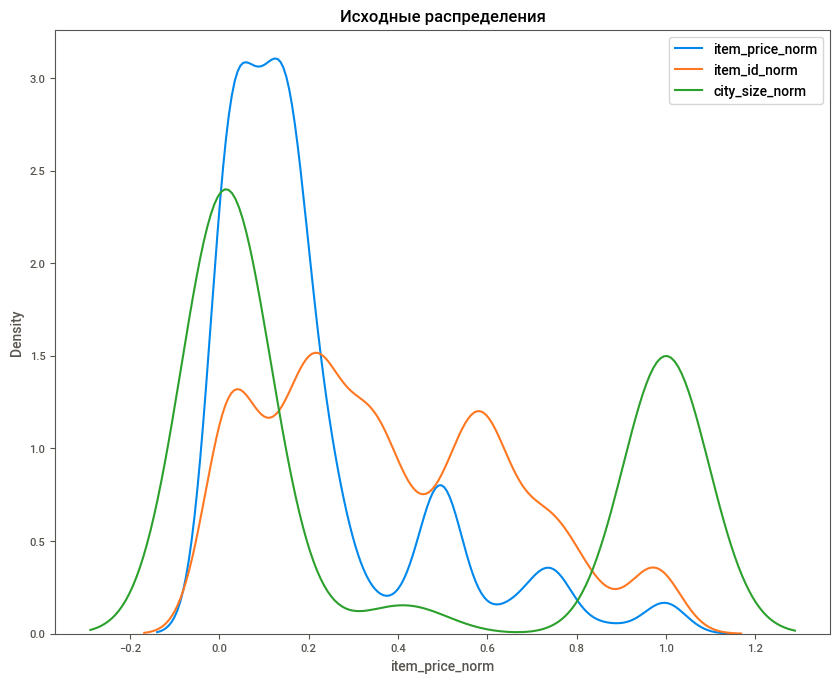

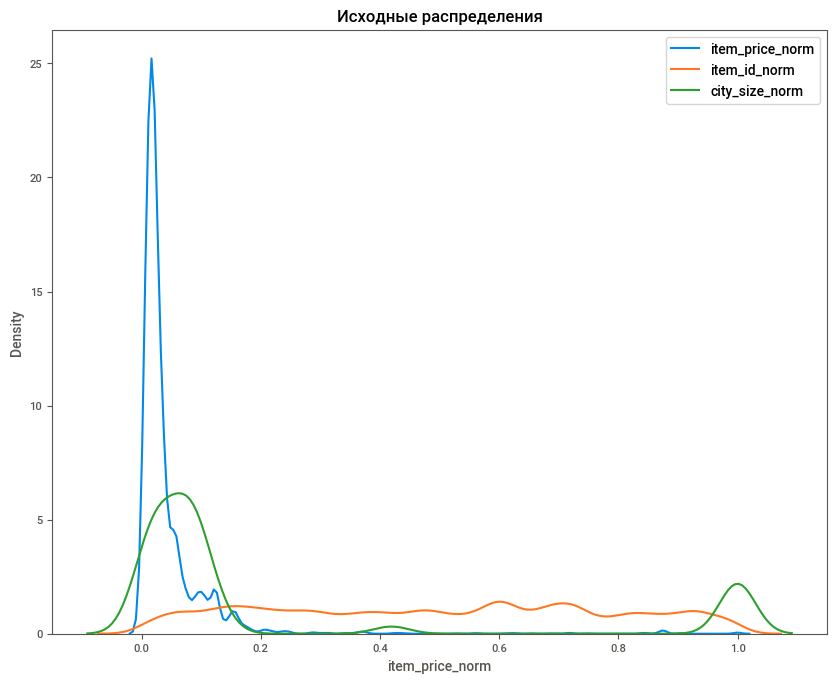

In [97]:
normal_chart(train_data, ['item_price_norm', 'item_id_norm', 'city_size_norm'])
normal_chart(test_data, ['item_price_norm', 'item_id_norm', 'city_size_norm'])

In [98]:
train_data.describe()

,item_id,date_block_num,shop_id,item_price,item_cnt_month,item_category_id,month,year,city_size,category_0,...,subcategory_2,subcategory_3,city_0,city_1,city_2,city_3,item_name_cat,item_id_norm,item_price_norm,city_size_norm
count,2727.00,2727.00,2727.00,2727.00,2727.00,2727.00,2727.00,2727.00,2727.00,2727.00,...,2727.00,2727.00,2727.00,2727.00,2727.00,2727.00,2727.00,2727.00,2727.00,2727.00
mean,9034.89,7.07,38.12,424.18,1.60,50.91,5.50,2013.21,4895404.84,0.06,...,0.33,0.78,0.03,0.13,0.49,0.58,187.70,0.38,0.21,0.39
std,5695.29,5.95,16.39,447.09,1.04,20.59,3.48,0.42,5707499.55,0.23,...,0.47,0.41,0.17,0.34,0.50,0.49,118.29,0.27,0.23,0.47
min,1123.00,0.00,0.00,13.00,1.00,1.00,1.00,2013.00,173160.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
25%,4613.00,2.00,27.00,109.00,1.00,39.00,2.00,2013.00,207425.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,97.50,0.17,0.05,0.00
50%,8056.00,6.00,40.00,299.00,1.00,59.00,5.00,2013.00,744554.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1.00,177.00,0.33,0.14,0.05
75%,13352.00,11.00,54.00,500.00,2.00,66.00,8.00,2013.00,12380664.00,0.00,...,1.00,1.00,0.00,0.00,1.00,1.00,283.00,0.58,0.25,1.00
max,22055.00,30.00,54.00,2000.00,5.00,82.00,12.00,2015.00,12380664.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,416.00,1.00,1.00,1.00


# 3. Multicollinearity analysis

In [99]:
train_data.columns

Index(['item_id', 'date_block_num', 'shop_id', 'item_price', 'item_cnt_month',
       'item_category_id', 'month', 'year', 'city_size', 'category_0',
       'category_1', 'category_2', 'category_3', 'subcategory_0',
       'subcategory_1', 'subcategory_2', 'subcategory_3', 'city_0', 'city_1',
       'city_2', 'city_3', 'item_name_cat', 'item_id_norm', 'item_price_norm',
       'city_size_norm'],
      dtype='object')

In [100]:
nat_cols = ['item_price_norm', 'item_id_norm', 'city_size_norm']

# categrorial signs
cat_cols = ['date_block_num', 'shop_id', 'item_cnt_month',
       'month', 'year', 'category_0', 'category_1', 'category_2', 'category_3',
       'subcategory_0', 'subcategory_1', 'subcategory_2', 'subcategory_3', 'city_0', 'city_1',
       'city_2', 'city_3', 'item_name_cat']

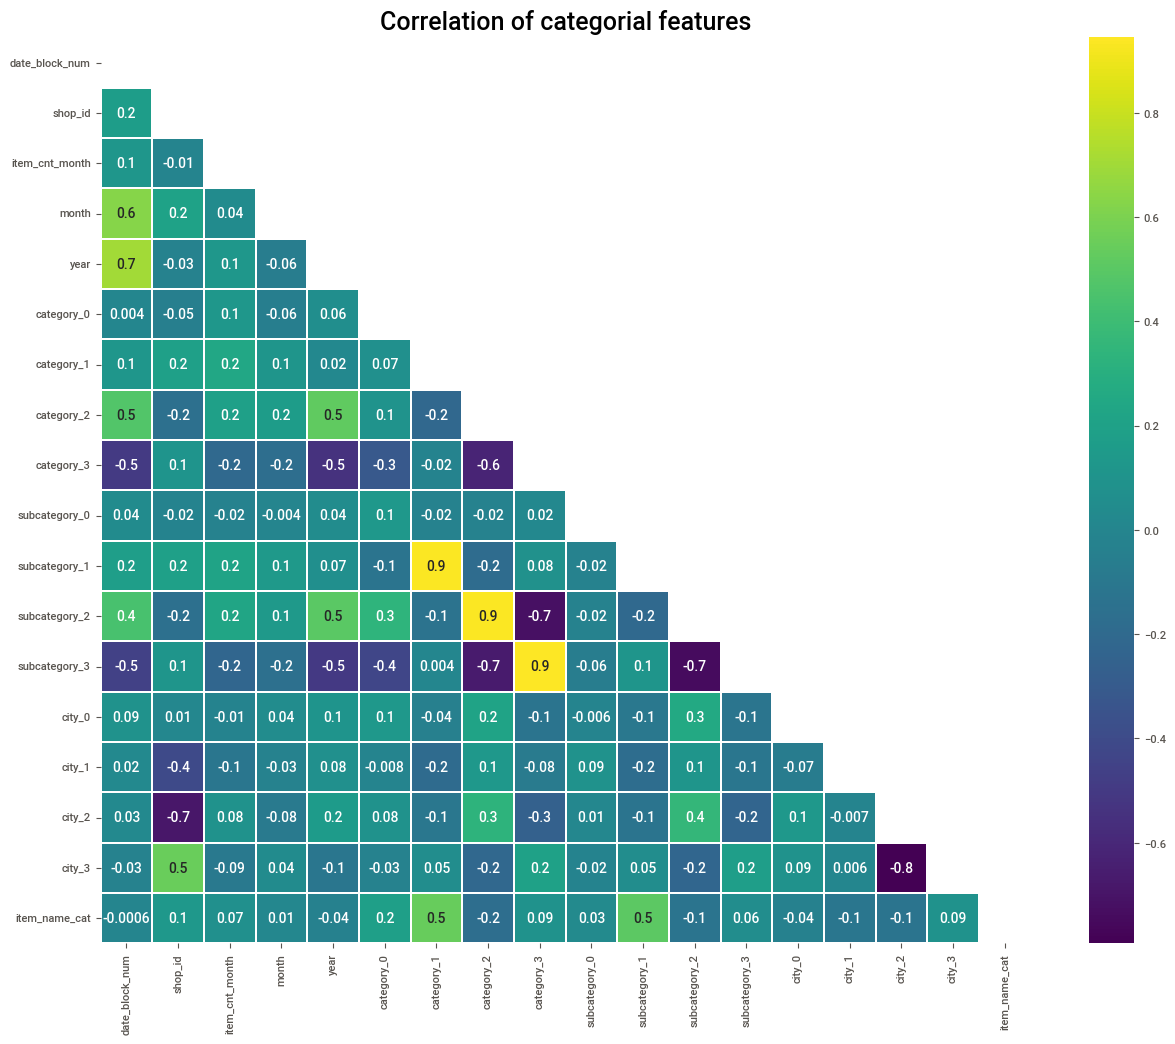

In [101]:
def correlation_chart(data, columns, method='pearson', title='Correlation'):
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = data[columns].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr, 
                annot=True, 
                linewidths=0.1, 
                ax=ax_, 
                mask=mask, 
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()

correlation_chart(train_data, cat_cols, 'spearman', 'Correlation of categorial features')

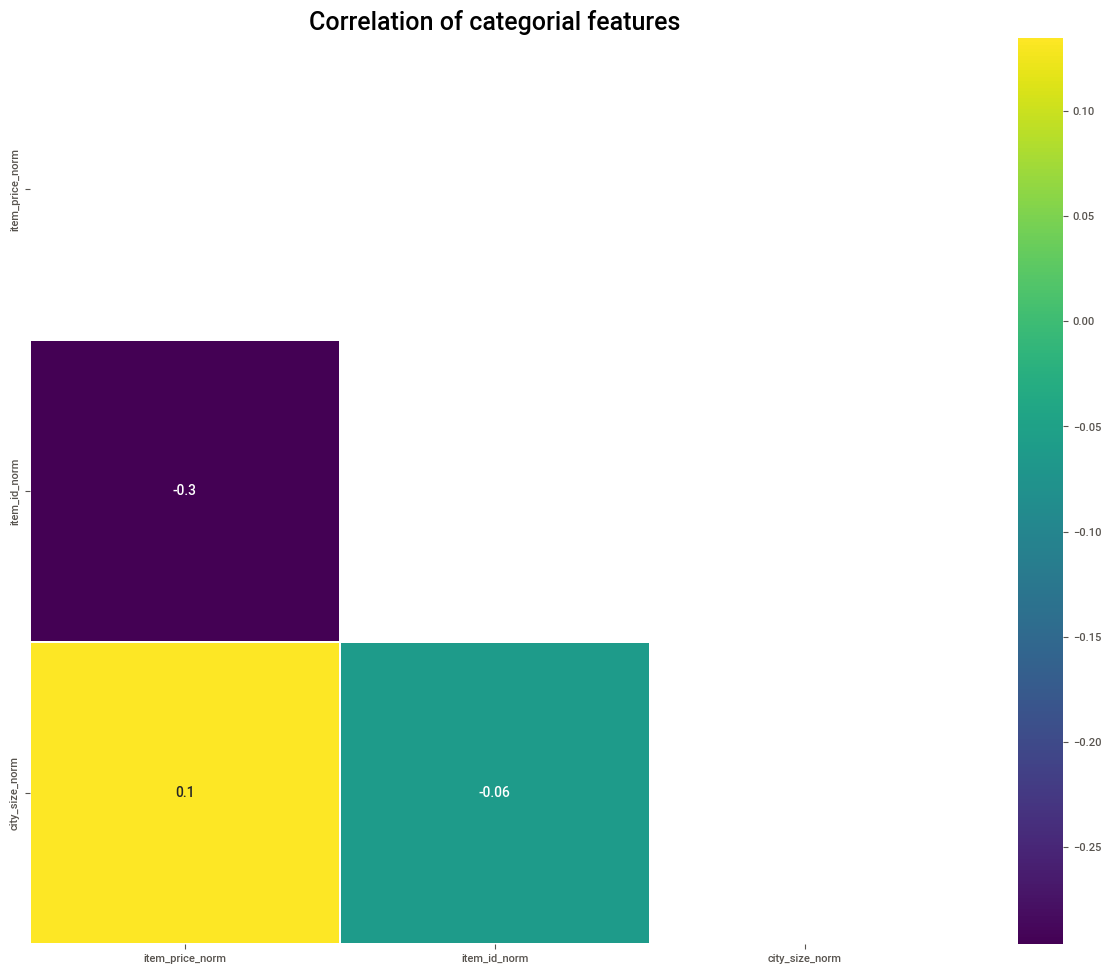

In [102]:
correlation_chart(train_data, nat_cols, 'pearson', 'Correlation of categorial features')

we can remove year column, becase of it has correlation more than 0.7

In [103]:
drop_columns = ['item_id', 'item_price', 'item_category_id', 'city_size',
                'subcategory_1', 'subcategory_2', 'subcategory_3', 'city_3']

test_data.drop(drop_columns, axis = 1, inplace=True)
train_data.drop(drop_columns, axis = 1, inplace=True)

## ASSESSMENT OF THE SIGNIFICANCE OF FEATURES

In [104]:
X = train_data.drop(['item_cnt_month'], axis = 1)  
y = train_data['item_cnt_month']

In [105]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2727 entries, 42991 to 1598593
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date_block_num   2727 non-null   int64  
 1   shop_id          2727 non-null   int64  
 2   item_cnt_month   2727 non-null   float64
 3   month            2727 non-null   int64  
 4   year             2727 non-null   int64  
 5   category_0       2727 non-null   int64  
 6   category_1       2727 non-null   int64  
 7   category_2       2727 non-null   int64  
 8   category_3       2727 non-null   int64  
 9   subcategory_0    2727 non-null   int64  
 10  city_0           2727 non-null   int64  
 11  city_1           2727 non-null   int64  
 12  city_2           2727 non-null   int64  
 13  item_name_cat    2727 non-null   int64  
 14  item_id_norm     2727 non-null   float64
 15  item_price_norm  2727 non-null   float64
 16  city_size_norm   2727 non-null   float64
dtypes: floa

<AxesSubplot:>

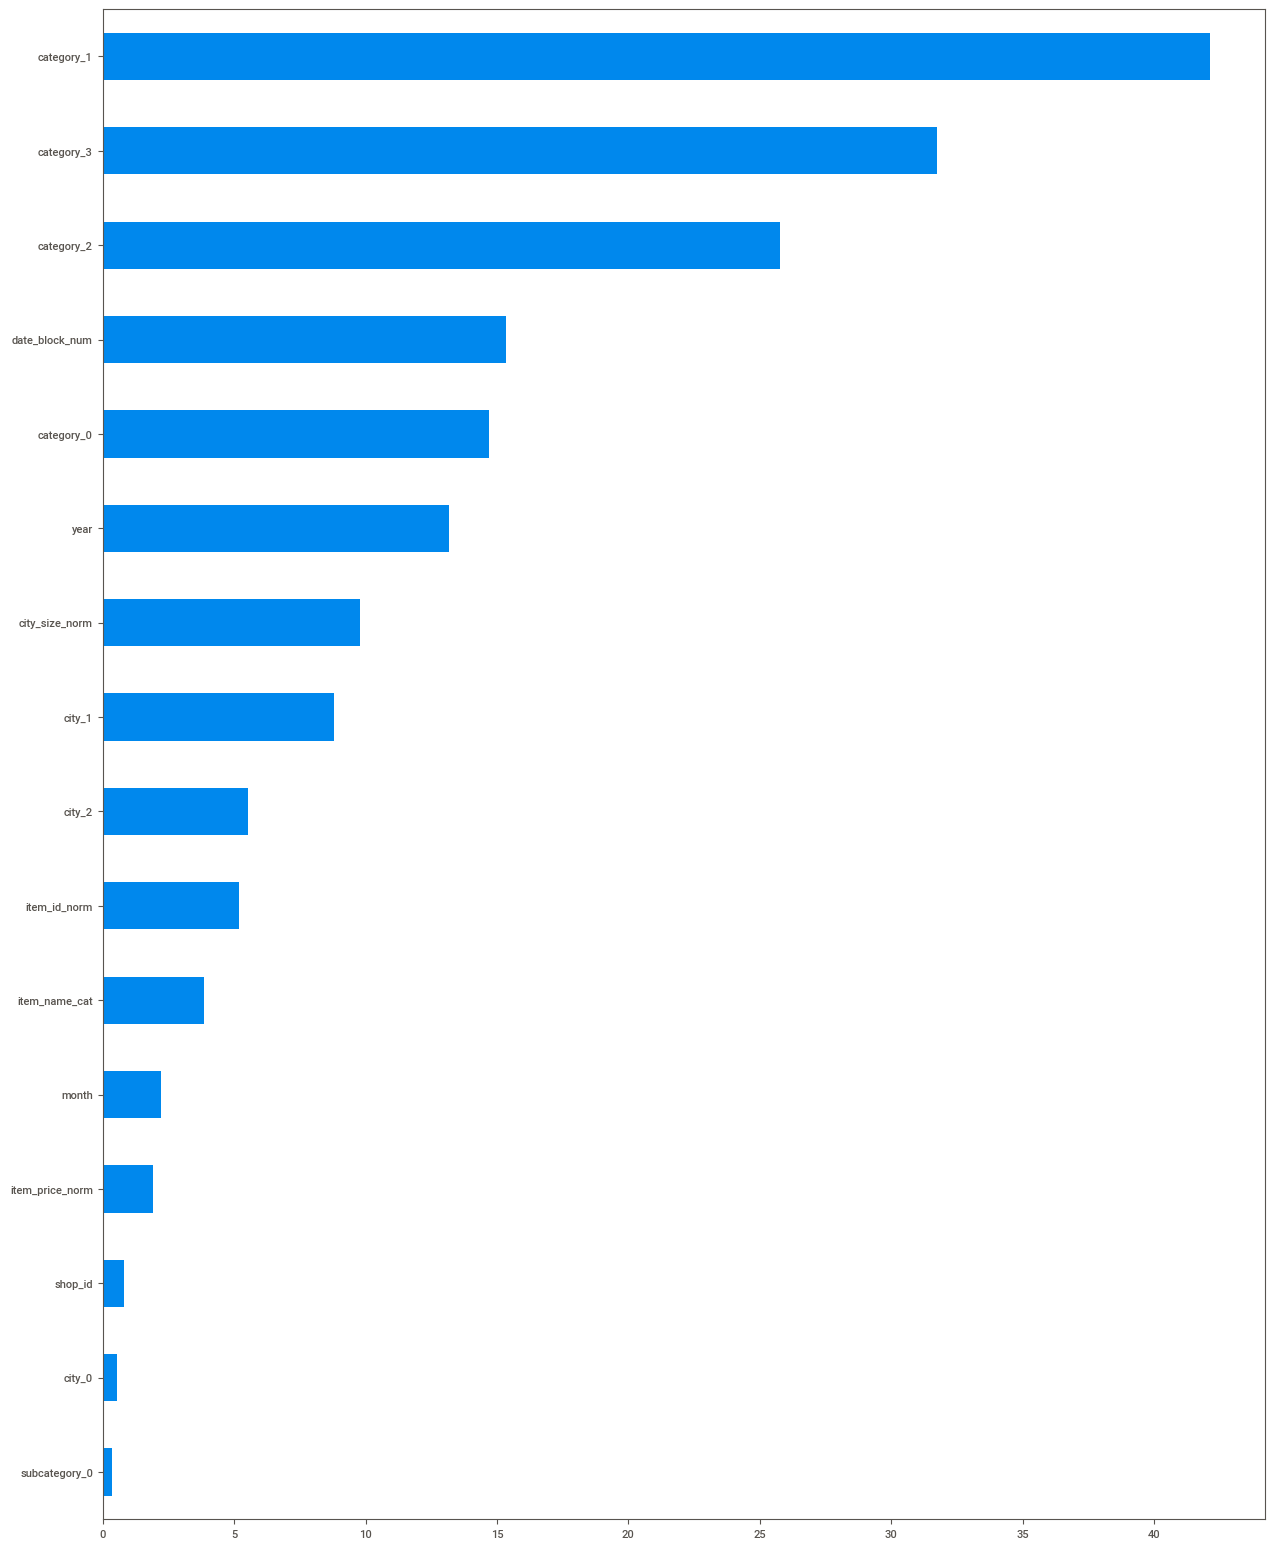

In [106]:
y=y.astype('int')

imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh')

# 4. Making model

In [107]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(214200, 2)


,ID,item_cnt_month
0,0,0.50
1,1,0.50
2,2,0.50
3,3,0.50
4,4,0.50


In [108]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (2181, 17), te_data = (546, 17)


,date_block_num,shop_id,item_cnt_month,month,year,category_0,category_1,category_2,category_3,subcategory_0,city_0,city_1,city_2,item_name_cat,item_id_norm,item_price_norm,city_size_norm
1561553,4,54,4.00,5,2013,0,1,0,1,0,0,0,0,405,0.97,0.05,0.00
1286597,7,30,1.00,8,2013,0,0,0,1,0,0,0,1,368,0.76,0.04,1.00
1561436,13,54,2.00,2,2014,0,1,0,1,0,0,0,0,403,0.97,0.02,0.00
43196,2,54,1.00,3,2013,0,0,0,1,0,0,0,0,3,0.00,0.17,0.00
658457,19,17,1.00,8,2014,0,0,1,0,0,0,1,1,179,0.33,0.25,0.07


In [109]:
# Task defenition
task = Task('reg', loss = 'mae', metric = 'mae')
# Roles setup
roles = {
    'target': TARGET_NAME,
}
#TabularUtilizedAutoML
automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

AutoML trainig

In [110]:
%%time
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[08:22:51] Start automl utilizator with listed constraints:
[08:22:51] - time: 1800.00 seconds
[08:22:51] - CPU: 4 cores
[08:22:51] - memory: 16 GB

[08:22:51] If one preset completes earlier, next preset configuration will be started

[08:22:51] ==================================================
[08:22:51] Start 0 automl preset configuration:
[08:22:51] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[08:22:51] Stdout logging level is INFO.
[08:22:51] Task: reg

[08:22:51] Start automl preset with listed constraints:
[08:22:51] - time: 1800.00 seconds
[08:22:51] - CPU: 4 cores
[08:22:51] - memory: 16 GB

[08:22:51] Train data shape: (2181, 17)

[08:22:55] Layer 1 train process start. Time left 1796.50 secs
[08:22:55] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[08:22:57] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.5250989738979891
[08:22:57] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicti

In [ ]:
print(automl.create_model_str_desc())

Final prediction for new objects = 
	0.30767 * 2 averaged models with config = "conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.89595 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.10405 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


	    Model #1.
		Final prediction for new objects (level 0) = 
			 0.43353 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.14690 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.41957 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


	+ 0.40158 * 1 averaged models with config = "conf_4_sel_type_0_no_int.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.66352 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.33648 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


	+ 0.29075 * 1 averaged models with config = "conf_5_sel_type_1_tuning_

Predict

In [ ]:
%%time
te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[2.5477343 ],
       [1.0334312 ],
       [1.0066842 ],
       [1.5787381 ],
       [1.9070812 ],
       [2.2131848 ],
       [1.2404966 ],
       [1.7284495 ],
       [1.004933  ],
       [1.000002  ],
       [1.0025097 ],
       [3.531186  ],
       [2.3446307 ],
       [1.0041608 ],
       [1.0231223 ],
       [1.0009404 ],
       [2.533958  ],
       [1.0025973 ],
       [1.4216865 ],
       [2.0616837 ],
       [2.3365793 ],
       [1.0024058 ],
       [1.753676  ],
       [1.0007788 ],
       [1.6243339 ],
       [2.3880424 ],
       [1.0029407 ],
       [1.0199223 ],
       [1.0330254 ],
       [1.9423006 ],
       [1.0001674 ],
       [1.0519795 ],
       [2.14356   ],
       [1.987514  ],
       [1.0356405 ],
       [1.0512552 ],
       [2.552816  ],
       [2.0579276 ],
       [1.7278663 ],
       [1.8927274 ],
       [1.0069553 ],
       [1.008065  ],
       [2.4801316 ],
       [1.0012567 ],
       [1.0011557 ],
       [1.3218268 ],
       [2.

In [ ]:
print(f'TRAIN out-of-fold score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

TRAIN out-of-fold score: 0.47916672110612213
HOLDOUT score: 0.5332286467045655


# 5. Feature importances calculation


For feature importances calculation we have 2 different methods in LightAutoML:

Fast (fast) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
Accurate (accurate) - this method calculate features permutation importances for the whole LightAutoML model based on the new labelled data. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).


CPU times: user 112 ms, sys: 67.4 ms, total: 180 ms
Wall time: 81.4 ms


<AxesSubplot:xlabel='Feature'>

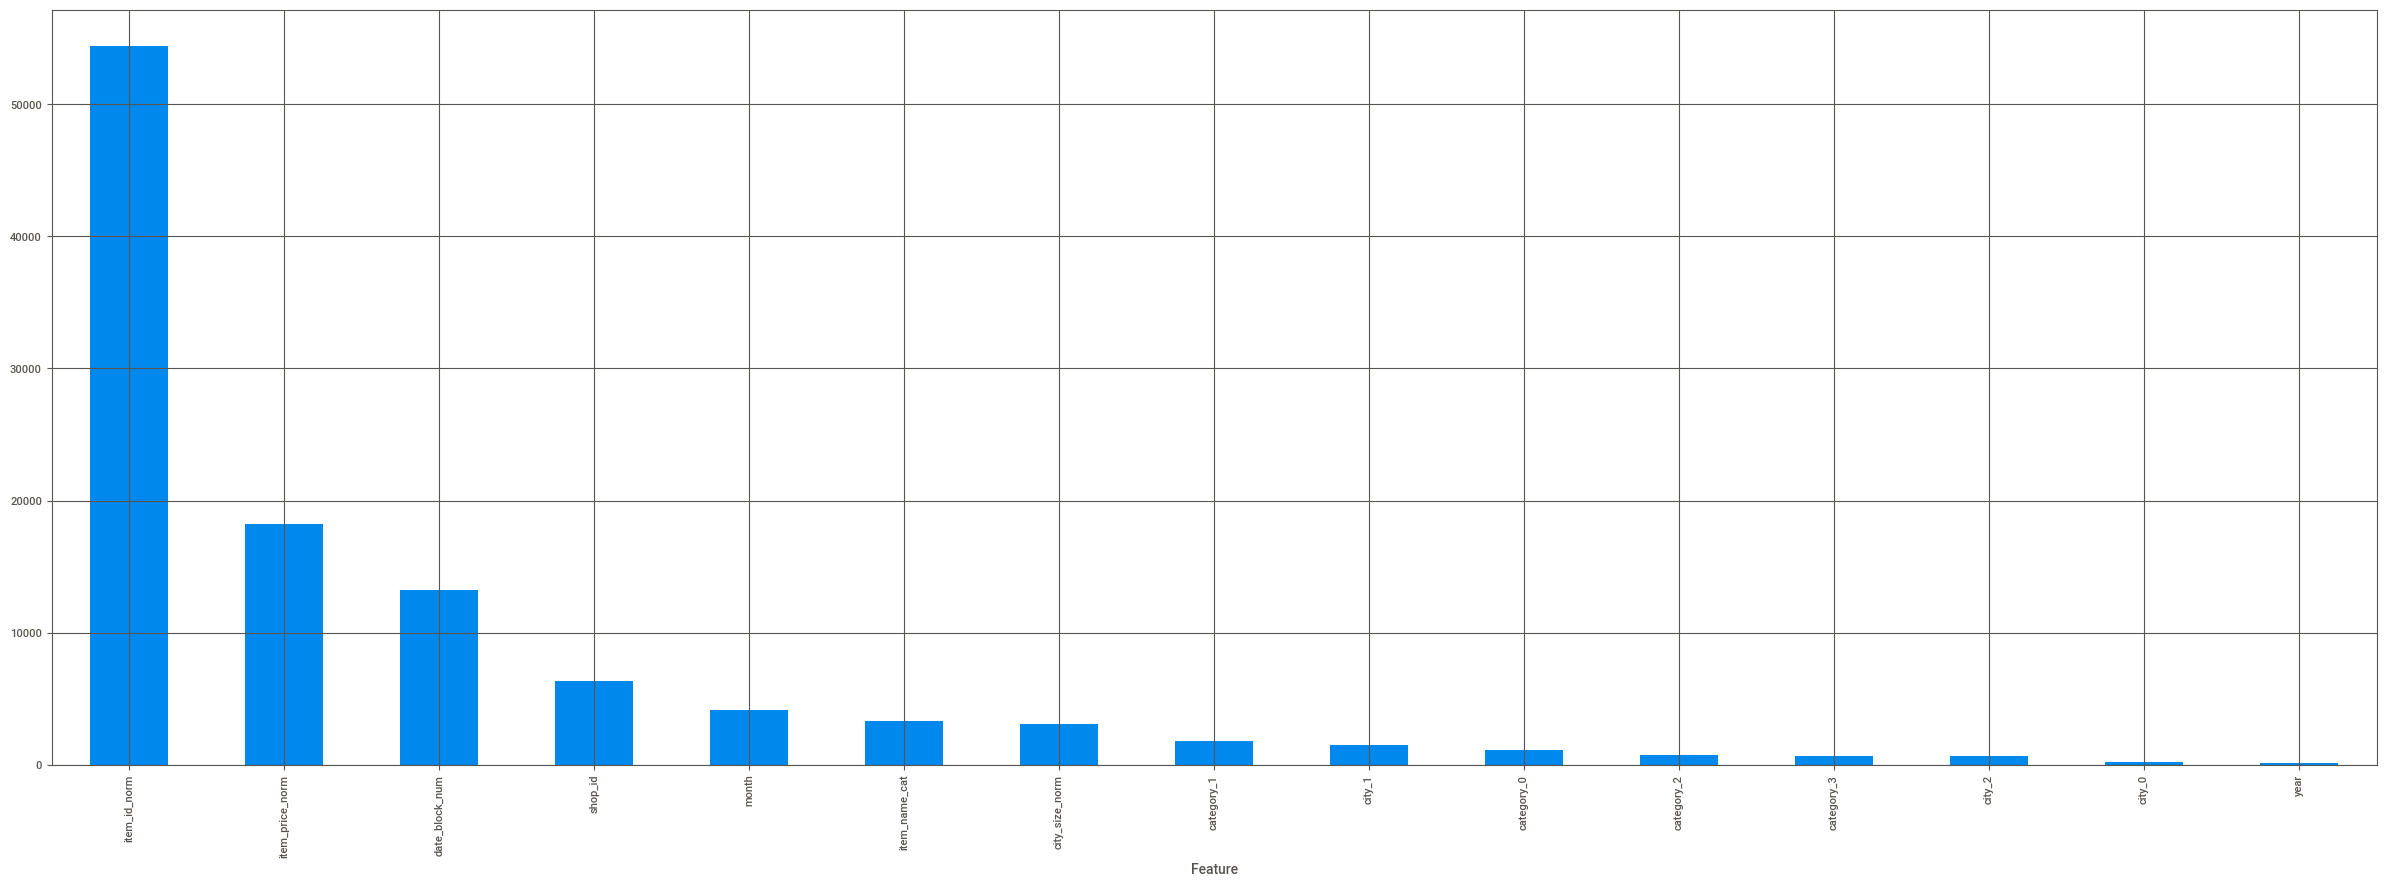

In [ ]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

CPU times: user 26.6 s, sys: 175 ms, total: 26.8 s
Wall time: 12.3 s


<AxesSubplot:xlabel='Feature'>

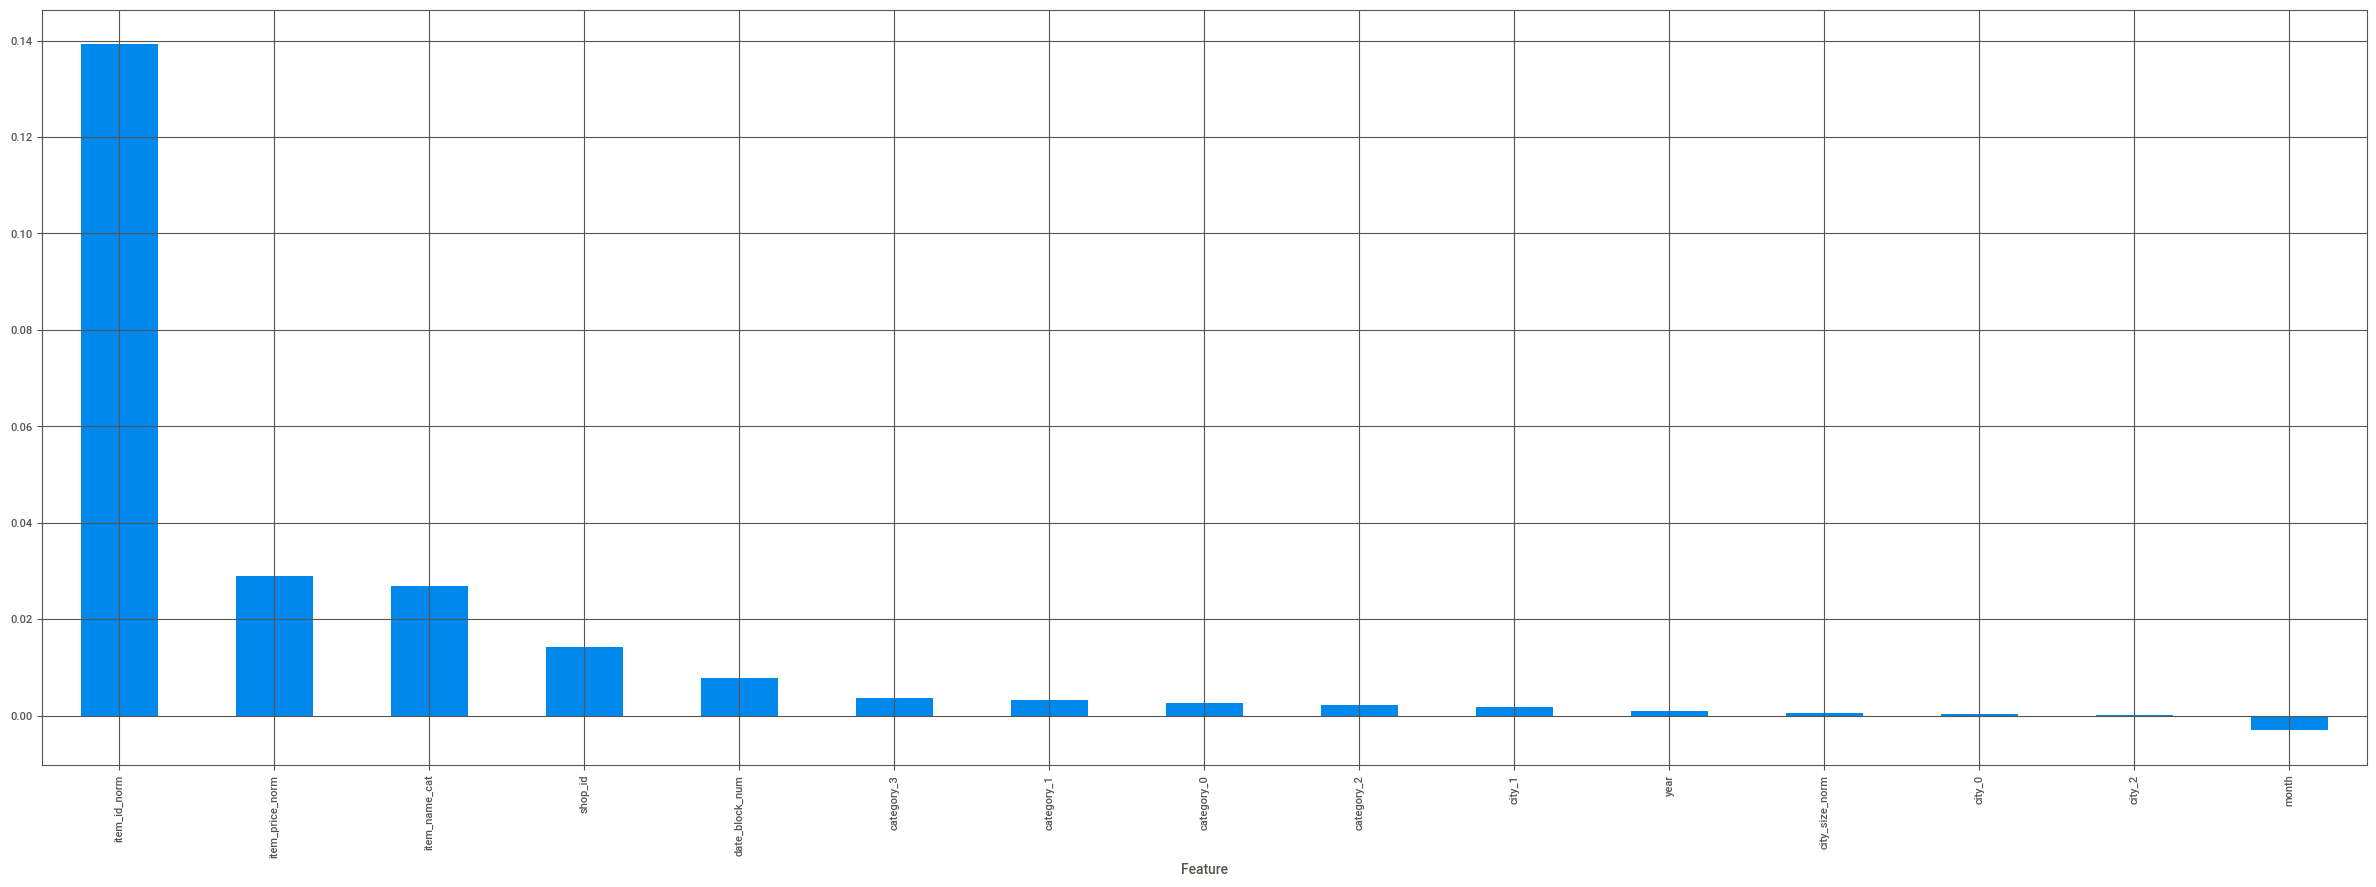

In [ ]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 6. Predict for test dataset

In [ ]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[1.1358904],
       [1.1128907],
       [1.1342146],
       ...,
       [1.0848527],
       [1.0959156],
       [1.094137 ]], dtype=float32)
Shape = (214200, 1)


In [ ]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission

,ID,item_cnt_month
0,0,1.14
1,1,1.11
2,2,1.13
3,3,1.13
4,4,1.13
...,...,...
214195,214195,1.08
214196,214196,1.10
214197,214197,1.08
214198,214198,1.10


In [ ]:
submission.to_csv('final.csv', index = False)